# Embedding Example

In [1]:
import matplotlib
matplotlib.rcParams['figure.max_open_warning'] = 0
import matplotlib.pyplot as plt

In [18]:
#import embedding as emb
import torch_geometric as tg
import local2global as l2g
import torch
import networkx as nx

#ADDED
#import patches as pt
#import network as ntw 
import autograd.numpy as anp
import pymanopt
import pymanopt.manifolds
import pymanopt.optimizers
import random
import local2global as l2g
import local2global.example as ex
import numpy as np

def double_intersections_nodes(patches):
    double_intersections=dict()
    for i in range(len(patches)):
        for j in range(i+1, len(patches)):
            double_intersections[(i,j)]=list(set(patches[i].nodes.tolist()).intersection(set(patches[j].nodes.tolist())))
    return double_intersections
    
import itertools


In [3]:
#import patches as pt
#import network as ntw 
import numpy as np
import geotorch
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import local2global as l2g


import local2global.example as ex
import local2global_embedding
from scipy.stats import ortho_group 
from tqdm.notebook import tqdm
from scipy.sparse import csr_matrix, csc_matrix, coo_matrix
import random
#import manopt_optimization as moptim
from torch_geometric.data import Data
import torch_geometric as tg
from local2global_embedding.network import tgraph
from local2global_embedding.patches import create_patch_data
from local2global_embedding.clustering import louvain_clustering
from tqdm.notebook import tqdm
import scipy.sparse as ss
import scipy.sparse.linalg as sl

import raphtory as rp
from raphtory import Graph as rgraph



import local2global as l2g

import local2global_embedding
from torch_geometric.utils.convert import from_networkx


#from Local2Global_embedding.local2global_embedding import  clustering
import community
#from Local2Global_embedding.local2global_embedding.network import graph
from local2global_embedding.network import TGraph

from torch_geometric.utils import to_networkx


from local2global import Patch
#import Local2Global_embedding.local2global_embedding.embedding.svd as svd
#import Local2Global_embedding.local2global_embedding.embedding.gae as gae
#import Local2Global_embedding.local2global_embedding.patches as patches


import torch_geometric as tg
import torch_scatter as ts
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import numpy as np 
import pandas as pd 
import torch 
import torch.nn.functional as F
import torch.optim as optim
#import optuna
#from optuna.trial import TrialState

from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
#from google.colab import drive, files
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.transforms import LargestConnectedComponents

In [33]:
def connected_components(data: tg.data.Data):
    """Find the (weakly)-connected components of graph data. Components are sorted by size, such that id=0 corresponds
     to the largest connected component"""
    edge_index = data.edge_index
    is_undir = tg.utils.is_undirected(edge_index)
    last_components = torch.full((data.num_nodes,), data.num_nodes, dtype=torch.long)
    components = torch.arange(data.num_nodes, dtype=torch.long)
    while not torch.equal(last_components, components):
        last_components[:] = components
        components = ts.scatter(last_components[edge_index[0]], edge_index[1], out=components, reduce='min')
        if not is_undir:
            components = ts.scatter(last_components[edge_index[1]], edge_index[0], out=components, reduce='min')
    component_id, inverse, component_size = torch.unique(components, return_counts=True, return_inverse=True)
    new_id = torch.argsort(component_size, descending=True)
    return new_id[inverse]


def largest_connected_component(data: tg.data.Data):
    """find largest connected component of data"""
    components = connected_components(data)
    nodes = torch.nonzero(components == 0).flatten()
    return induced_subgraph(data, nodes)


def induced_subgraph(data: tg.data.Data, nodes, extend_hops=0):
    nodes = torch.as_tensor(nodes, dtype=torch.long)
    if extend_hops > 0:
        nodes, edge_index, node_map, edge_mask = tg.utils.k_hop_subgraph(nodes, num_hops=extend_hops,
                                                                         edge_index=data.edge_index,
                                                                         relabel_nodes=True)
        edge_attr = data.edge_attr[edge_mask, :] if data.edge_attr is not None else None
    else:
        edge_index, edge_attr = tg.utils.subgraph(nodes, data.edge_index, data.edge_attr, relabel_nodes=True)

    subgraph = tg.data.Data(edge_index=edge_index, edge_attr=edge_attr)
    for key, value in data.__dict__.items():
        if not key.startswith('edge'):
            if hasattr(value, 'shape') and value.shape[0] == data.num_nodes:
                setattr(subgraph, key, value[nodes])
            else:
                setattr(subgraph, key, value)
    subgraph.nodes = nodes
    subgraph.num_nodes = len(nodes)
    return subgraph


def conductance(graph: TGraph, source, target=None):
    if target is None:
        target_mask = torch.ones(graph.num_nodes, dtype=torch.bool, device=graph.device)
        target_mask[source] = False
    else:
        target_mask = torch.zeros(graph.num_nodes, dtype=torch.bool)
        target_mask[target] = True
    out = torch.cat([graph.adj(node) for node in source])
    cond = torch.sum(target_mask[out]).float()
    s_deg = graph.degree[source].sum()
    t_deg = graph.num_edges-s_deg if target is None else graph.degree[target].sum()
    cond /= torch.minimum(s_deg, t_deg)
    return cond


def speye(n, dtype=torch.float):
    """identity matrix of dimension n as sparse_coo_tensor."""
    return torch.sparse_coo_tensor(torch.tile(torch.arange(n, dtype=torch.long), (2, 1)),
                                   torch.ones(n, dtype=dtype),
                                   (n, n))


class DistanceDecoder(torch.nn.Module):
    def __init__(self):
        super(DistanceDecoder, self).__init__()
        self.dist = torch.nn.PairwiseDistance()

    def forward(self, z, edge_index, sigmoid=True):
        value = -self.dist(z[edge_index[0]], z[edge_index[1]])
        return torch.sigmoid(value) if sigmoid else value

    def forward_all(self, z, sigmoid=True):
        adj = torch.cdist(z, z)
        return torch.sigmoid(adj) if sigmoid else adj


class GAEconv(torch.nn.Module):
    def __init__(self, dim, num_node_features, hidden_dim=32, cached=True, bias=True, add_self_loops=True, normalize=True):
        super().__init__()
        self.conv1 = tg.nn.GCNConv(num_node_features, hidden_dim, cached=cached, bias=bias, add_self_loops=add_self_loops,
                                   normalize=normalize)
        self.conv2 = tg.nn.GCNConv(hidden_dim, dim, cached=cached, bias=bias, add_self_loops=add_self_loops,
                                   normalize=normalize)

    def forward(self, data):
        edge_index = data.edge_index
        x = F.relu(self.conv1(data.x, edge_index))
        return self.conv2(x, edge_index)


class VGAEconv(torch.nn.Module):
    def __init__(self, dim, num_node_features, hidden_dim=32, cached=True, bias=True, add_self_loops=True, normalize=True):
        super().__init__()
        self.conv1 = tg.nn.GCNConv(num_node_features, hidden_dim, cached=cached, bias=bias, add_self_loops=add_self_loops,
                                   normalize=normalize)
        self.mean_conv2 = tg.nn.GCNConv(hidden_dim, dim, cached=cached, bias=bias, add_self_loops=add_self_loops,
                                        normalize=normalize)
        self.var_conv2 = tg.nn.GCNConv(hidden_dim, dim, cached=cached, bias=bias, add_self_loops=add_self_loops,
                                       normalize=normalize)

    def forward(self, data: tg.data.Data):
        x = data.x
        edge_index = data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)

        mu = self.mean_conv2(x, edge_index)
        sigma = self.var_conv2(x, edge_index)
        return mu, sigma


def VGAE_loss(model, data):
    return model.recon_loss(model.encode(data), data.edge_index) + model.kl_loss() / data.num_nodes


def VGAE_model(dim, hidden_dim, num_features, dist=False):
    if dist:
        return tg.nn.VGAE(encoder=VGAEconv(dim, num_node_features=num_features, hidden_dim=hidden_dim),
                          decoder=DistanceDecoder())
    else:
        return tg.nn.VGAE(encoder=VGAEconv(dim, num_node_features=num_features, hidden_dim=hidden_dim))


def lr_grid_search(data, model, loss_fun, validation_loss_fun, lr_grid=(0.1, 0.01, 0.005, 0.001),
                   num_epochs=10, runs=1, verbose=True):
    val_loss = torch.zeros((len(lr_grid), runs))
    val_start = torch.zeros((len(lr_grid), runs))
    for i, lr in enumerate(lr_grid):
        for r in range(runs):
            model.reset_parameters()
            val_start[i, r] = validation_loss_fun(model, data)
            model = train(data, model, loss_fun, num_epochs=num_epochs, lr=lr, verbose=verbose)
            val_loss[i, r] = validation_loss_fun(model, data)
    model.reset_parameters()
    return lr_grid[torch.argmax(torch.mean(val_loss, 1))], val_loss, val_start


def train(data, model, loss_fun, num_epochs=100, verbose=True, lr=0.01, logger=lambda loss: None):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    # schedule = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
    for e in range(num_epochs):
        optimizer.zero_grad()
        loss = loss_fun(model, data)
        loss.backward()
        optimizer.step()
        logger(float(loss))
        if verbose:
            print(f'epoch {e}: loss={loss.item()}')
        # schedule.step()
    return model


def VGAE_patch_embeddings(patch_data, dim=2, hidden_dim=32, num_epochs=100, decoder=None, device='cpu', lr=0.01):
    patch_list = []
    models = []
    for patch in patch_data:
        #for i in range(len(patch)):#added this for loop and replace the commented part with this
            #if patch[i].x is None:
                #patch[i].x=speye(patch[i].num_nodes)
        
        
        if patch.x is None:
            patch.x = speye(patch.num_nodes)
        print(f"training patch with {patch.edge_index.shape[1]} edges")   #added [i] to every patch
        model = tg.nn.VGAE(encoder=VGAEconv(dim, patch.x.shape[1], hidden_dim=hidden_dim), decoder=decoder).to(device)
        patch.to(device)

        def loss_fun(model, data):
            return model.recon_loss(model.encode(data), data.edge_index) + model.kl_loss() / data.num_nodes

        model = train(patch, model, loss_fun, num_epochs=num_epochs, lr=lr)
        with torch.no_grad():
            model.eval()
            coordinates = model.encode(patch).to('cpu').numpy()
            models.append(model)
            patch_list.append(l2g.Patch(patch.nodes.to('cpu').numpy(), coordinates))
    return patch_list, models


def GAE_patch_embeddings(patch_data, dim=2, hidden_dim=32, num_epochs=100, device='cpu', decoder=None, lr=0.01):
    patch_list = []
    models = []
    for patch in patch_data:
        if patch.x is None:
            patch.x = speye(patch.num_nodes)
        print(f"training patch with {patch.edge_index.shape[1]} edges")
        model = tg.nn.GAE(encoder=GAEconv(dim, patch.x.shape[1], hidden_dim=hidden_dim), decoder=decoder).to(device)
        patch.to(device)

        def loss_fun(model, data):
            return model.recon_loss(model.encode(data), data.edge_index)
        model.train()
        model = train(patch, model, loss_fun, num_epochs=num_epochs, lr=lr)
        model.eval()
        coordinates = model.encode(patch).to('cpu').data.numpy()
        patch.to('cpu')
        models.append(model)
        patch_list.append(l2g.Patch(patch.nodes.numpy(), coordinates))
    return patch_list, models

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
test_data = tg.datasets.Planetoid(name='Cora', root='/tmp/cora', split='full')[0]

test_data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [6]:
from local2global_embedding.patches import create_patch_data
from local2global_embedding.clustering import louvain_clustering

In [7]:
cc = largest_connected_component(data=test_data)
cc.x=test_data.x[cc.nodes] 
cc.y=test_data.y[cc.nodes]
test_data=cc

TG=TGraph(edge_index=cc.edge_index, edge_attr=cc.edge_attr,  num_nodes=cc.num_nodes, ensure_sorted=True, undir=False)
pt, pgraph= create_patch_data(TG, partition_tensor= louvain_clustering(TG),
                                           min_overlap=90, target_overlap=200, verbose=True)
patch_data = [induced_subgraph(cc, p) for p in pt]

number of patches: 15
average patch degree: 3.7333333333333334


enlarging patch overlaps:   0%|          | 0/15 [00:00<?, ?it/s]

In [8]:
neg_edges = tg.utils.negative_sampling(test_data.edge_index, num_nodes=test_data.num_nodes)

In [9]:
clustered_data=patch_data

In [10]:
patch_data

[Data(edge_index=[2, 2032], nodes=[547], num_nodes=547),
 Data(edge_index=[2, 1946], nodes=[525], num_nodes=525),
 Data(edge_index=[2, 1878], nodes=[462], num_nodes=462),
 Data(edge_index=[2, 2784], nodes=[699], num_nodes=699),
 Data(edge_index=[2, 1652], nodes=[446], num_nodes=446),
 Data(edge_index=[2, 840], nodes=[264], num_nodes=264),
 Data(edge_index=[2, 1460], nodes=[378], num_nodes=378),
 Data(edge_index=[2, 764], nodes=[216], num_nodes=216),
 Data(edge_index=[2, 950], nodes=[271], num_nodes=271),
 Data(edge_index=[2, 2922], nodes=[755], num_nodes=755),
 Data(edge_index=[2, 1698], nodes=[450], num_nodes=450),
 Data(edge_index=[2, 670], nodes=[207], num_nodes=207),
 Data(edge_index=[2, 1602], nodes=[448], num_nodes=448),
 Data(edge_index=[2, 1800], nodes=[443], num_nodes=443),
 Data(edge_index=[2, 1844], nodes=[489], num_nodes=489)]

In [11]:
dim=2

## Inner product embedding

In [12]:
patches_ip, models_ip =VGAE_patch_embeddings(clustered_data, num_epochs=200)


full_model_ip = tg.nn.VGAE(encoder=VGAEconv(2, test_data.num_node_features))
full_model_ip = train(test_data, full_model_ip,
                   loss_fun=lambda model, data: model.recon_loss(model.encode(data), data.edge_index) + model.kl_loss()/data.num_nodes,
                   num_epochs=200)

training patch with 2032 edges
epoch 0: loss=1.7243188619613647
epoch 1: loss=1.632159948348999
epoch 2: loss=1.611518383026123
epoch 3: loss=1.5940577983856201
epoch 4: loss=1.5413583517074585
epoch 5: loss=1.5101364850997925
epoch 6: loss=1.5186572074890137
epoch 7: loss=1.483724594116211
epoch 8: loss=1.4543147087097168
epoch 9: loss=1.4352599382400513
epoch 10: loss=1.4214564561843872
epoch 11: loss=1.3983361721038818
epoch 12: loss=1.3864978551864624
epoch 13: loss=1.3725509643554688
epoch 14: loss=1.3763784170150757
epoch 15: loss=1.3573023080825806
epoch 16: loss=1.3457894325256348
epoch 17: loss=1.3432679176330566
epoch 18: loss=1.318755865097046
epoch 19: loss=1.3315213918685913
epoch 20: loss=1.3213562965393066
epoch 21: loss=1.3107296228408813
epoch 22: loss=1.3025370836257935
epoch 23: loss=1.29985511302948
epoch 24: loss=1.288236379623413
epoch 25: loss=1.2933447360992432
epoch 26: loss=1.2741914987564087
epoch 27: loss=1.273916482925415
epoch 28: loss=1.2706875801086426
e

epoch 43: loss=1.2376641035079956
epoch 44: loss=1.2266218662261963
epoch 45: loss=1.208970069885254
epoch 46: loss=1.1994282007217407
epoch 47: loss=1.1935542821884155
epoch 48: loss=1.1794607639312744
epoch 49: loss=1.1667749881744385
epoch 50: loss=1.1436814069747925
epoch 51: loss=1.1270116567611694
epoch 52: loss=1.1201107501983643
epoch 53: loss=1.1431154012680054
epoch 54: loss=1.1266615390777588
epoch 55: loss=1.1390289068222046
epoch 56: loss=1.1260184049606323
epoch 57: loss=1.1066174507141113
epoch 58: loss=1.1413722038269043
epoch 59: loss=1.104918360710144
epoch 60: loss=1.1219594478607178
epoch 61: loss=1.0772724151611328
epoch 62: loss=1.0986559391021729
epoch 63: loss=1.0839557647705078
epoch 64: loss=1.1045222282409668
epoch 65: loss=1.0928564071655273
epoch 66: loss=1.080430030822754
epoch 67: loss=1.088850736618042
epoch 68: loss=1.0731730461120605
epoch 69: loss=1.07463538646698
epoch 70: loss=1.0385866165161133
epoch 71: loss=1.0433228015899658
epoch 72: loss=1.028

epoch 104: loss=0.9872140884399414
epoch 105: loss=1.0012446641921997
epoch 106: loss=0.9813932180404663
epoch 107: loss=1.000144600868225
epoch 108: loss=0.9732341170310974
epoch 109: loss=0.9873720407485962
epoch 110: loss=0.98686683177948
epoch 111: loss=1.0179290771484375
epoch 112: loss=0.9866254329681396
epoch 113: loss=0.9879934191703796
epoch 114: loss=0.9781863689422607
epoch 115: loss=1.0040041208267212
epoch 116: loss=0.9844132661819458
epoch 117: loss=0.9974520802497864
epoch 118: loss=0.999420702457428
epoch 119: loss=0.994133710861206
epoch 120: loss=0.9801547527313232
epoch 121: loss=0.972014844417572
epoch 122: loss=0.9843537211418152
epoch 123: loss=0.9885801076889038
epoch 124: loss=0.9905703663825989
epoch 125: loss=1.003961205482483
epoch 126: loss=0.9985594153404236
epoch 127: loss=0.9856363534927368
epoch 128: loss=0.9709442853927612
epoch 129: loss=0.9765706658363342
epoch 130: loss=0.9955944418907166
epoch 131: loss=0.9637917280197144
epoch 132: loss=0.991220653

epoch 177: loss=0.9337664842605591
epoch 178: loss=0.9707657098770142
epoch 179: loss=0.942715585231781
epoch 180: loss=0.9716030955314636
epoch 181: loss=0.9520891308784485
epoch 182: loss=0.9632971286773682
epoch 183: loss=0.9528834819793701
epoch 184: loss=0.9579883813858032
epoch 185: loss=0.9478664398193359
epoch 186: loss=0.9707210063934326
epoch 187: loss=0.9624890685081482
epoch 188: loss=0.9488144516944885
epoch 189: loss=0.9722074270248413
epoch 190: loss=0.9685782194137573
epoch 191: loss=0.9489490389823914
epoch 192: loss=0.9730926156044006
epoch 193: loss=0.9695573449134827
epoch 194: loss=0.9396728873252869
epoch 195: loss=0.9506189227104187
epoch 196: loss=0.9763022661209106
epoch 197: loss=0.937048077583313
epoch 198: loss=0.9661986827850342
epoch 199: loss=0.9479267597198486
training patch with 1652 edges
epoch 0: loss=1.7342280149459839
epoch 1: loss=1.6876510381698608
epoch 2: loss=1.587348222732544
epoch 3: loss=1.5689148902893066
epoch 4: loss=1.5703543424606323
ep

epoch 65: loss=1.0360774993896484
epoch 66: loss=1.0645073652267456
epoch 67: loss=1.016201376914978
epoch 68: loss=1.0295366048812866
epoch 69: loss=1.0240541696548462
epoch 70: loss=0.9927130341529846
epoch 71: loss=1.01851487159729
epoch 72: loss=1.0063074827194214
epoch 73: loss=0.9777759313583374
epoch 74: loss=0.9913766980171204
epoch 75: loss=0.9913200736045837
epoch 76: loss=0.9885441064834595
epoch 77: loss=0.9883134961128235
epoch 78: loss=0.9748944044113159
epoch 79: loss=0.9995884299278259
epoch 80: loss=0.9717932939529419
epoch 81: loss=0.9474152326583862
epoch 82: loss=0.9481330513954163
epoch 83: loss=0.989234447479248
epoch 84: loss=0.950275182723999
epoch 85: loss=0.9965720772743225
epoch 86: loss=0.9379376173019409
epoch 87: loss=0.9888905882835388
epoch 88: loss=0.9782651662826538
epoch 89: loss=0.9635607004165649
epoch 90: loss=0.9686891436576843
epoch 91: loss=0.9837499260902405
epoch 92: loss=0.9656471610069275
epoch 93: loss=0.9365776181221008
epoch 94: loss=0.96

epoch 133: loss=0.9660568833351135
epoch 134: loss=0.9809668660163879
epoch 135: loss=0.9763145446777344
epoch 136: loss=0.943857729434967
epoch 137: loss=0.9693209528923035
epoch 138: loss=0.975113034248352
epoch 139: loss=0.9885708689689636
epoch 140: loss=0.9750410914421082
epoch 141: loss=0.9776111245155334
epoch 142: loss=0.963723361492157
epoch 143: loss=0.966632604598999
epoch 144: loss=0.9888356924057007
epoch 145: loss=0.9785770773887634
epoch 146: loss=0.9399605393409729
epoch 147: loss=0.9716765880584717
epoch 148: loss=0.9606712460517883
epoch 149: loss=0.9694646596908569
epoch 150: loss=0.9465963244438171
epoch 151: loss=0.9475286602973938
epoch 152: loss=0.9672245383262634
epoch 153: loss=0.9912872314453125
epoch 154: loss=0.9633947610855103
epoch 155: loss=0.9718809127807617
epoch 156: loss=0.9290706515312195
epoch 157: loss=0.9667032957077026
epoch 158: loss=0.9400699734687805
epoch 159: loss=0.9602625370025635
epoch 160: loss=0.9626091718673706
epoch 161: loss=0.967613

epoch 21: loss=1.3312456607818604
epoch 22: loss=1.3312115669250488
epoch 23: loss=1.3235067129135132
epoch 24: loss=1.340876579284668
epoch 25: loss=1.3353629112243652
epoch 26: loss=1.3008800745010376
epoch 27: loss=1.3025559186935425
epoch 28: loss=1.3017823696136475
epoch 29: loss=1.2942415475845337
epoch 30: loss=1.277106761932373
epoch 31: loss=1.2835018634796143
epoch 32: loss=1.2787327766418457
epoch 33: loss=1.2749435901641846
epoch 34: loss=1.2508660554885864
epoch 35: loss=1.265893578529358
epoch 36: loss=1.241459608078003
epoch 37: loss=1.2267171144485474
epoch 38: loss=1.2221081256866455
epoch 39: loss=1.2310409545898438
epoch 40: loss=1.1917622089385986
epoch 41: loss=1.1871126890182495
epoch 42: loss=1.1814943552017212
epoch 43: loss=1.1641547679901123
epoch 44: loss=1.1502195596694946
epoch 45: loss=1.1372075080871582
epoch 46: loss=1.1240781545639038
epoch 47: loss=1.1549221277236938
epoch 48: loss=1.152178168296814
epoch 49: loss=1.1329643726348877
epoch 50: loss=1.14

epoch 66: loss=1.06574285030365
epoch 67: loss=1.0508238077163696
epoch 68: loss=1.056668996810913
epoch 69: loss=1.0316697359085083
epoch 70: loss=1.0238103866577148
epoch 71: loss=1.0132369995117188
epoch 72: loss=1.0239392518997192
epoch 73: loss=1.004417061805725
epoch 74: loss=1.0237464904785156
epoch 75: loss=1.0343583822250366
epoch 76: loss=1.009037733078003
epoch 77: loss=0.9945571422576904
epoch 78: loss=1.0141962766647339
epoch 79: loss=1.0020349025726318
epoch 80: loss=1.0212372541427612
epoch 81: loss=1.005260944366455
epoch 82: loss=0.9964708089828491
epoch 83: loss=1.0050524473190308
epoch 84: loss=1.0117896795272827
epoch 85: loss=1.001702070236206
epoch 86: loss=1.0037637948989868
epoch 87: loss=0.9903850555419922
epoch 88: loss=0.9740118384361267
epoch 89: loss=0.9975845217704773
epoch 90: loss=0.9907179474830627
epoch 91: loss=0.9864047765731812
epoch 92: loss=0.9908843040466309
epoch 93: loss=0.9769662022590637
epoch 94: loss=0.9973914623260498
epoch 95: loss=0.9922

epoch 148: loss=0.988488495349884
epoch 149: loss=0.9793978929519653
epoch 150: loss=0.9693446159362793
epoch 151: loss=0.9558926820755005
epoch 152: loss=0.9606722593307495
epoch 153: loss=0.9503278136253357
epoch 154: loss=0.9876106977462769
epoch 155: loss=0.9843312501907349
epoch 156: loss=0.975551187992096
epoch 157: loss=0.9797118306159973
epoch 158: loss=0.9860350489616394
epoch 159: loss=0.975692868232727
epoch 160: loss=0.9802927374839783
epoch 161: loss=0.9833927154541016
epoch 162: loss=0.9936062693595886
epoch 163: loss=0.9763416647911072
epoch 164: loss=0.9889683127403259
epoch 165: loss=0.947036862373352
epoch 166: loss=0.9720444679260254
epoch 167: loss=0.9619520902633667
epoch 168: loss=0.9686275124549866
epoch 169: loss=0.9697490930557251
epoch 170: loss=0.9815670251846313
epoch 171: loss=0.9784315824508667
epoch 172: loss=0.9790658354759216
epoch 173: loss=0.9688547253608704
epoch 174: loss=0.9813115000724792
epoch 175: loss=0.981040358543396
epoch 176: loss=0.9626297

epoch 35: loss=1.316788911819458
epoch 36: loss=1.3120273351669312
epoch 37: loss=1.307877779006958
epoch 38: loss=1.3012804985046387
epoch 39: loss=1.286802887916565
epoch 40: loss=1.2885971069335938
epoch 41: loss=1.2918729782104492
epoch 42: loss=1.2775810956954956
epoch 43: loss=1.2686982154846191
epoch 44: loss=1.270656943321228
epoch 45: loss=1.253581166267395
epoch 46: loss=1.248507022857666
epoch 47: loss=1.2415443658828735
epoch 48: loss=1.2125471830368042
epoch 49: loss=1.2053217887878418
epoch 50: loss=1.1970685720443726
epoch 51: loss=1.1858251094818115
epoch 52: loss=1.180923581123352
epoch 53: loss=1.1594321727752686
epoch 54: loss=1.1553620100021362
epoch 55: loss=1.1397331953048706
epoch 56: loss=1.12147057056427
epoch 57: loss=1.1595511436462402
epoch 58: loss=1.135593056678772
epoch 59: loss=1.104264736175537
epoch 60: loss=1.1057476997375488
epoch 61: loss=1.1258119344711304
epoch 62: loss=1.0887477397918701
epoch 63: loss=1.1092456579208374
epoch 64: loss=1.09378588

epoch 117: loss=1.0183721780776978
epoch 118: loss=1.0204812288284302
epoch 119: loss=0.9957618713378906
epoch 120: loss=1.0046775341033936
epoch 121: loss=0.9991852045059204
epoch 122: loss=0.9960452318191528
epoch 123: loss=1.0134131908416748
epoch 124: loss=0.9944544434547424
epoch 125: loss=0.9915669560432434
epoch 126: loss=1.0051946640014648
epoch 127: loss=1.002321720123291
epoch 128: loss=1.0123167037963867
epoch 129: loss=0.9958204627037048
epoch 130: loss=1.010258436203003
epoch 131: loss=1.0248215198516846
epoch 132: loss=1.0144680738449097
epoch 133: loss=1.0020498037338257
epoch 134: loss=1.0085821151733398
epoch 135: loss=0.9908104538917542
epoch 136: loss=0.9995095133781433
epoch 137: loss=1.0041853189468384
epoch 138: loss=0.9825147986412048
epoch 139: loss=0.99178546667099
epoch 140: loss=1.000339388847351
epoch 141: loss=0.9849673509597778
epoch 142: loss=0.996453583240509
epoch 143: loss=0.9952039122581482
epoch 144: loss=1.0150893926620483
epoch 145: loss=0.99236899

epoch 190: loss=0.9514940977096558
epoch 191: loss=0.9640604257583618
epoch 192: loss=0.9531933665275574
epoch 193: loss=0.9486161470413208
epoch 194: loss=0.9496850371360779
epoch 195: loss=0.9752622842788696
epoch 196: loss=0.957108199596405
epoch 197: loss=0.9521901607513428
epoch 198: loss=0.9514334201812744
epoch 199: loss=0.9380388855934143
epoch 0: loss=1.8456562757492065
epoch 1: loss=1.549060344696045
epoch 2: loss=1.4568008184432983
epoch 3: loss=1.4095110893249512
epoch 4: loss=1.376611590385437
epoch 5: loss=1.3643499612808228
epoch 6: loss=1.3522616624832153
epoch 7: loss=1.3418574333190918
epoch 8: loss=1.3327921628952026
epoch 9: loss=1.3188669681549072
epoch 10: loss=1.301016092300415
epoch 11: loss=1.2831889390945435
epoch 12: loss=1.2552622556686401
epoch 13: loss=1.2218995094299316
epoch 14: loss=1.2012784481048584
epoch 15: loss=1.168204426765442
epoch 16: loss=1.1605054140090942
epoch 17: loss=1.1494297981262207
epoch 18: loss=1.1525391340255737
epoch 19: loss=1.16

In [13]:
with torch.no_grad():
    coord_ip = full_model_ip.encode(test_data).numpy()
prob_ip = l2g.utils.WeightedAlignmentProblem(patches_ip)
stitched_ip = prob_ip.get_aligned_embedding(scale=False)
prob_ip_s = l2g.utils.WeightedAlignmentProblem(patches_ip)
stitched_ip_scaled = prob_ip_s.get_aligned_embedding(scale=True)



Compute relative transformations:   0%|          | 0/170 [00:00<?, ?it/s]

Compute mean embedding:   0%|          | 0/15 [00:00<?, ?it/s]

Compute relative transformations:   0%|          | 0/170 [00:00<?, ?it/s]

Compute relative transformations:   0%|          | 0/170 [00:00<?, ?it/s]

Compute mean embedding:   0%|          | 0/15 [00:00<?, ?it/s]

In [14]:
#plt.figure()
#plt.scatter(coord_ip[:, 0], coord_ip[:, 1], c=test_data.y, s=0.5)
auc, ap = full_model_ip.test(torch.tensor(coord_ip), test_data.edge_index, neg_edges)
print(f'Full model (inner product)\n AUC: {auc:.3}, AP: {ap:.3}')

#plt.figure()
#plt.scatter(stitched_ip[:, 0], stitched_ip[:, 1], c=test_data.y, s=0.5)
auc, ap = full_model_ip.test(torch.tensor(stitched_ip), test_data.edge_index, neg_edges)
print(f'Patched (inner product, no scaling)\n AUC: {auc:.3}, AP: {ap:.3}')

#plt.figure()
#plt.scatter(stitched_ip_scaled[:, 0], stitched_ip_scaled[:, 1], c=test_data.y, s=0.5)
auc, ap = full_model_ip.test(torch.tensor(stitched_ip_scaled), test_data.edge_index, neg_edges)
print(f'Patched (inner product, scaling)\n AUC: {auc:.3}, AP: {ap:.3}')

Full model (inner product)
 AUC: 0.938, AP: 0.928
Patched (inner product, no scaling)
 AUC: 0.849, AP: 0.851
Patched (inner product, scaling)
 AUC: 0.848, AP: 0.85


In [29]:
def double_intersections_nodes(patches):
    double_intersections = dict()
    for i in range(len(patches)):
        for j in range(i+1, len(patches)):
            double_intersections[(i,j)]=list(set(patches[i].nodes.tolist()).intersection(set(patches[j].nodes.tolist())))
    return double_intersections

def preprocess_graphs(list_of_patches, nodes_dict):
    emb_list = []
    for i in range(len(list_of_patches)-1):
        emb_list.append([torch.tensor(list_of_patches[i].get_coordinates(list(nodes_dict[i,i+1]))),
                         torch.tensor(list_of_patches[i+1].get_coordinates(list(nodes_dict[i,i+1])))])
    emb_list = list(itertools.chain.from_iterable(emb_list))
    return emb_list    

def get_embedding(patches, result):
    n=len(patches)
    rot=[result.transformation[i].weight.to('cpu').detach().numpy() for i in range(n)]
    shift=[result.transformation[i].bias.to('cpu').detach().numpy() for i in range(n)]

    emb_problem = l2g.AlignmentProblem(patches)
    embedding = np.empty((emb_problem.n_nodes, emb_problem.dim))
    for node, patch_list in enumerate(emb_problem.patch_index):
        embedding[node] = np.mean([emb_problem.patches[p].get_coordinate(node)@rot[i] + shift[i] for i, p in enumerate(patch_list)], axis=0)

    #prob=l2g.AlignmentProblem(patches)
    #old_embedding=prob.get_aligned_embedding()
    #embedding=embedding[nodes]
    #old_embedding=old_embedding[nodes]
    #error= l2g.utils.procrustes_error(embedding,old_embedding)

    return embedding


import torch
import torch.nn as nn
import geotorch


    
class Model(nn.Module):
    def __init__(self, dim, n_patches, device):
        super().__init__()
        self.device = device
        self.transformation = nn.ParameterList([nn.Linear(dim, dim).to(device) for _ in range(n_patches)])
        [geotorch.orthogonal(self.transformation[i], 'weight') for i in range(n_patches)]
    
    def forward(self, patch_emb):
        m = len(patch_emb)
        transformations = [self.transformation[0]] + [item for i in range(1, len(self.transformation)-1) for item in (self.transformation[i], self.transformation[i])] + [self.transformation[-1]]
        transformed_emb = [transformations[i](patch_emb[i]) for i in range(m)]
        return transformed_emb

def loss_function(transformed_emb):
    m = len(transformed_emb)
    diff = [transformed_emb[i] - transformed_emb[i+1] for i in range(0, m-1, 2)]
    loss = sum([torch.norm(d) ** 2 for d in diff])
    return loss

def train_model(patch_emb, dim, n_patches, num_epochs=100, learning_rate=0.05):
    #device = get_device()
    patch_emb = [p.to(device) for p in patch_emb]
    
    model = Model(dim, n_patches, device).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_hist = []
    
    for epoch in tqdm(range(num_epochs)):
        optimizer.zero_grad()
        transformed_patch_emb = model(patch_emb)
        loss = loss_function(transformed_patch_emb)
        loss.backward(retain_graph=True)
        optimizer.step()
        loss_hist.append(loss.item())
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")
    
    return model, loss_hist


In [20]:
nodes = double_intersections_nodes(patches_ip)
emb_patches = preprocess_graphs(patches_ip, nodes)
n_patches=len(patches_ip)

In [27]:
res, loss_hist= train_model(emb_patches, dim, n_patches , num_epochs=100, learning_rate=0.5)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0, Loss: 4699.0556640625
Epoch 10, Loss: 1783.2232666015625
Epoch 20, Loss: 1433.77490234375
Epoch 30, Loss: 1368.1026611328125
Epoch 40, Loss: 1329.916748046875
Epoch 50, Loss: 1323.81787109375
Epoch 60, Loss: 1319.9105224609375
Epoch 70, Loss: 1317.864501953125
Epoch 80, Loss: 1317.092529296875
Epoch 90, Loss: 1316.8154296875


In [30]:
emb=get_embedding(patches_ip, res)

In [31]:
auc, ap = full_model_ip.test(torch.tensor(emb), test_data.edge_index, neg_edges)
print(f'New model (inner product)\n AUC: {auc:.3}, AP: {ap:.3}')


New model (inner product)
 AUC: 0.605, AP: 0.614


In [80]:
dimensions=[16, 32, 64, 128, 256, 512]
AUC=[]
AP=[]
Loss=[]
PATCHES=[]
new_emb=[]
for dim in dimensions:
    patches_ip, models_ip =VGAE_patch_embeddings(clustered_data, dim=dim, num_epochs=200, device=device)
    PATCHES.append(patches_ip)
    emb_patches = preprocess_graphs(patches_ip, nodes)
    res, loss_hist= train_model(emb_patches, dim, n_patches , num_epochs=200, learning_rate=0.05)
    emb=get_embedding(patches_ip, res)
    new_emb.append(emb)
    auc, ap = full_model_ip.test(torch.tensor(emb), test_data.edge_index, neg_edges)
    AUC.append(auc)
    AP.append(ap)
    Loss.append(loss_hist)
    

training patch with 2032 edges
epoch 0: loss=3.3986566066741943
epoch 1: loss=3.3478448390960693
epoch 2: loss=3.1182992458343506
epoch 3: loss=3.0222055912017822
epoch 4: loss=2.786128520965576
epoch 5: loss=2.6789097785949707
epoch 6: loss=2.639350652694702
epoch 7: loss=2.3458974361419678
epoch 8: loss=2.287757635116577
epoch 9: loss=2.0472328662872314
epoch 10: loss=1.8978854417800903
epoch 11: loss=1.8305450677871704
epoch 12: loss=1.6323258876800537
epoch 13: loss=1.5871329307556152
epoch 14: loss=1.561279535293579
epoch 15: loss=1.4889137744903564
epoch 16: loss=1.5075721740722656
epoch 17: loss=1.4364111423492432
epoch 18: loss=1.3854860067367554
epoch 19: loss=1.3832141160964966
epoch 20: loss=1.359315276145935
epoch 21: loss=1.361457347869873
epoch 22: loss=1.3499833345413208
epoch 23: loss=1.3336818218231201
epoch 24: loss=1.3332680463790894
epoch 25: loss=1.329282283782959
epoch 26: loss=1.3155933618545532
epoch 27: loss=1.325365662574768
epoch 28: loss=1.3127660751342773
e

epoch 53: loss=1.0591739416122437
epoch 54: loss=1.0511671304702759
epoch 55: loss=1.0481287240982056
epoch 56: loss=1.0398125648498535
epoch 57: loss=1.063916802406311
epoch 58: loss=1.0496491193771362
epoch 59: loss=1.036171793937683
epoch 60: loss=1.0133086442947388
epoch 61: loss=1.0467957258224487
epoch 62: loss=1.0132426023483276
epoch 63: loss=1.0251315832138062
epoch 64: loss=1.0098947286605835
epoch 65: loss=1.0038303136825562
epoch 66: loss=1.0002106428146362
epoch 67: loss=1.0126560926437378
epoch 68: loss=1.0007076263427734
epoch 69: loss=0.9903979897499084
epoch 70: loss=0.9946185350418091
epoch 71: loss=0.9904890060424805
epoch 72: loss=0.9816367030143738
epoch 73: loss=0.9899682402610779
epoch 74: loss=0.9736414551734924
epoch 75: loss=0.9569082856178284
epoch 76: loss=0.9526605606079102
epoch 77: loss=0.9550020098686218
epoch 78: loss=0.9710550308227539
epoch 79: loss=0.9711295366287231
epoch 80: loss=0.9272361993789673
epoch 81: loss=0.9533448815345764
epoch 82: loss=0

epoch 92: loss=0.9796119332313538
epoch 93: loss=0.9735143780708313
epoch 94: loss=0.9653749465942383
epoch 95: loss=0.9909051656723022
epoch 96: loss=0.9891476035118103
epoch 97: loss=0.9546013474464417
epoch 98: loss=0.9512089490890503
epoch 99: loss=0.965653121471405
epoch 100: loss=0.9599363803863525
epoch 101: loss=0.968749463558197
epoch 102: loss=0.9492027759552002
epoch 103: loss=0.945140540599823
epoch 104: loss=0.9745830297470093
epoch 105: loss=0.9548458456993103
epoch 106: loss=0.9567510485649109
epoch 107: loss=0.9442875981330872
epoch 108: loss=0.9578222036361694
epoch 109: loss=0.9630523920059204
epoch 110: loss=0.9302175045013428
epoch 111: loss=0.9309954047203064
epoch 112: loss=0.9214199185371399
epoch 113: loss=0.9646043181419373
epoch 114: loss=0.9367775917053223
epoch 115: loss=0.9267193675041199
epoch 116: loss=0.9538291692733765
epoch 117: loss=0.9515711069107056
epoch 118: loss=0.9531995058059692
epoch 119: loss=0.9468303918838501
epoch 120: loss=0.9355005025863

epoch 144: loss=0.9074097275733948
epoch 145: loss=0.9052301049232483
epoch 146: loss=0.9069111943244934
epoch 147: loss=0.9075474143028259
epoch 148: loss=0.9242653250694275
epoch 149: loss=0.8997429013252258
epoch 150: loss=0.907029390335083
epoch 151: loss=0.907759428024292
epoch 152: loss=0.9084305763244629
epoch 153: loss=0.9078860282897949
epoch 154: loss=0.9151200652122498
epoch 155: loss=0.9135448336601257
epoch 156: loss=0.9152041673660278
epoch 157: loss=0.9068751931190491
epoch 158: loss=0.9098508358001709
epoch 159: loss=0.9080380797386169
epoch 160: loss=0.9173400402069092
epoch 161: loss=0.9130635857582092
epoch 162: loss=0.8963544368743896
epoch 163: loss=0.8896448612213135
epoch 164: loss=0.8959211111068726
epoch 165: loss=0.8915961980819702
epoch 166: loss=0.9092096090316772
epoch 167: loss=0.9052610397338867
epoch 168: loss=0.9030297994613647
epoch 169: loss=0.8976718187332153
epoch 170: loss=0.9126006960868835
epoch 171: loss=0.901109516620636
epoch 172: loss=0.88801

epoch 183: loss=0.9138327240943909
epoch 184: loss=0.8824769258499146
epoch 185: loss=0.8821443915367126
epoch 186: loss=0.8823468089103699
epoch 187: loss=0.8808212876319885
epoch 188: loss=0.8851411938667297
epoch 189: loss=0.9017014503479004
epoch 190: loss=0.9011037349700928
epoch 191: loss=0.894504964351654
epoch 192: loss=0.8674469590187073
epoch 193: loss=0.8915278315544128
epoch 194: loss=0.8866019248962402
epoch 195: loss=0.9048728346824646
epoch 196: loss=0.9082432389259338
epoch 197: loss=0.9145575165748596
epoch 198: loss=0.8844689726829529
epoch 199: loss=0.9054481387138367
training patch with 840 edges
epoch 0: loss=3.4604809284210205
epoch 1: loss=3.301443099975586
epoch 2: loss=3.4059319496154785
epoch 3: loss=2.813950300216675
epoch 4: loss=2.950381278991699
epoch 5: loss=2.628608465194702
epoch 6: loss=2.55922269821167
epoch 7: loss=2.312016010284424
epoch 8: loss=2.2743308544158936
epoch 9: loss=2.1523783206939697
epoch 10: loss=2.123608112335205
epoch 11: loss=1.957

epoch 21: loss=1.409946322441101
epoch 22: loss=1.4027186632156372
epoch 23: loss=1.365415334701538
epoch 24: loss=1.366999864578247
epoch 25: loss=1.3473654985427856
epoch 26: loss=1.3343591690063477
epoch 27: loss=1.3353300094604492
epoch 28: loss=1.329161524772644
epoch 29: loss=1.3417024612426758
epoch 30: loss=1.329026699066162
epoch 31: loss=1.3088845014572144
epoch 32: loss=1.309170126914978
epoch 33: loss=1.3146394491195679
epoch 34: loss=1.3099133968353271
epoch 35: loss=1.310732126235962
epoch 36: loss=1.2876461744308472
epoch 37: loss=1.2941749095916748
epoch 38: loss=1.2952231168746948
epoch 39: loss=1.2806625366210938
epoch 40: loss=1.2801589965820312
epoch 41: loss=1.2656595706939697
epoch 42: loss=1.2464839220046997
epoch 43: loss=1.2495156526565552
epoch 44: loss=1.220668077468872
epoch 45: loss=1.2327216863632202
epoch 46: loss=1.2083030939102173
epoch 47: loss=1.1956703662872314
epoch 48: loss=1.1903184652328491
epoch 49: loss=1.1618403196334839
epoch 50: loss=1.15696

epoch 88: loss=0.9948784112930298
epoch 89: loss=1.0078822374343872
epoch 90: loss=1.0126291513442993
epoch 91: loss=0.99781733751297
epoch 92: loss=0.9892934560775757
epoch 93: loss=1.0313811302185059
epoch 94: loss=0.9840373992919922
epoch 95: loss=0.9648672342300415
epoch 96: loss=0.9857882857322693
epoch 97: loss=1.011049747467041
epoch 98: loss=0.9984176158905029
epoch 99: loss=0.9715820550918579
epoch 100: loss=1.0331453084945679
epoch 101: loss=0.9804840087890625
epoch 102: loss=0.9761210680007935
epoch 103: loss=0.9580686092376709
epoch 104: loss=1.0315344333648682
epoch 105: loss=0.9895340204238892
epoch 106: loss=0.9950416088104248
epoch 107: loss=0.9741066098213196
epoch 108: loss=0.9944552779197693
epoch 109: loss=1.0205062627792358
epoch 110: loss=0.9904329776763916
epoch 111: loss=0.9242121577262878
epoch 112: loss=0.9939509034156799
epoch 113: loss=0.9989476203918457
epoch 114: loss=1.0128718614578247
epoch 115: loss=1.0417871475219727
epoch 116: loss=0.9803323745727539


epoch 131: loss=0.9358357787132263
epoch 132: loss=0.9083746075630188
epoch 133: loss=0.9393647909164429
epoch 134: loss=0.9828271865844727
epoch 135: loss=0.9299856424331665
epoch 136: loss=0.9210565686225891
epoch 137: loss=0.9823822975158691
epoch 138: loss=0.9379072785377502
epoch 139: loss=0.9433542490005493
epoch 140: loss=0.945783257484436
epoch 141: loss=0.94046550989151
epoch 142: loss=0.9406839609146118
epoch 143: loss=0.912475049495697
epoch 144: loss=0.9713327884674072
epoch 145: loss=0.9788255095481873
epoch 146: loss=0.9429653882980347
epoch 147: loss=0.965003252029419
epoch 148: loss=0.9321985840797424
epoch 149: loss=0.9376527070999146
epoch 150: loss=0.9492974281311035
epoch 151: loss=0.9441171288490295
epoch 152: loss=0.9362340569496155
epoch 153: loss=0.9390416145324707
epoch 154: loss=0.9555574059486389
epoch 155: loss=0.9301636219024658
epoch 156: loss=0.9392398595809937
epoch 157: loss=0.9615236520767212
epoch 158: loss=0.9406017065048218
epoch 159: loss=0.9396861

epoch 175: loss=0.8634317517280579
epoch 176: loss=0.8765566945075989
epoch 177: loss=0.8672898411750793
epoch 178: loss=0.8694071173667908
epoch 179: loss=0.8726522922515869
epoch 180: loss=0.8513546586036682
epoch 181: loss=0.8517888784408569
epoch 182: loss=0.8653855323791504
epoch 183: loss=0.8687834739685059
epoch 184: loss=0.8562811017036438
epoch 185: loss=0.8387676477432251
epoch 186: loss=0.8500394225120544
epoch 187: loss=0.8612136840820312
epoch 188: loss=0.8656240701675415
epoch 189: loss=0.865398645401001
epoch 190: loss=0.8471773266792297
epoch 191: loss=0.8508503437042236
epoch 192: loss=0.8721508979797363
epoch 193: loss=0.8419848084449768
epoch 194: loss=0.8584167957305908
epoch 195: loss=0.8406509757041931
epoch 196: loss=0.8601792454719543
epoch 197: loss=0.8502452373504639
epoch 198: loss=0.8550387024879456
epoch 199: loss=0.8427844047546387
training patch with 1698 edges
epoch 0: loss=3.3845043182373047
epoch 1: loss=3.3330328464508057
epoch 2: loss=3.2039372920989

epoch 21: loss=1.4371616840362549
epoch 22: loss=1.4488859176635742
epoch 23: loss=1.4336459636688232
epoch 24: loss=1.4505287408828735
epoch 25: loss=1.4154404401779175
epoch 26: loss=1.4132190942764282
epoch 27: loss=1.4096519947052002
epoch 28: loss=1.4221515655517578
epoch 29: loss=1.4078532457351685
epoch 30: loss=1.4255715608596802
epoch 31: loss=1.4043607711791992
epoch 32: loss=1.3828818798065186
epoch 33: loss=1.391711711883545
epoch 34: loss=1.3850125074386597
epoch 35: loss=1.369911789894104
epoch 36: loss=1.3540253639221191
epoch 37: loss=1.3394463062286377
epoch 38: loss=1.3230946063995361
epoch 39: loss=1.3032304048538208
epoch 40: loss=1.292325735092163
epoch 41: loss=1.2697557210922241
epoch 42: loss=1.2369308471679688
epoch 43: loss=1.210784673690796
epoch 44: loss=1.1722438335418701
epoch 45: loss=1.1507166624069214
epoch 46: loss=1.131935477256775
epoch 47: loss=1.1265732049942017
epoch 48: loss=1.159786581993103
epoch 49: loss=1.12692391872406
epoch 50: loss=1.10658

epoch 66: loss=0.9939759969711304
epoch 67: loss=0.9633857607841492
epoch 68: loss=0.9759173393249512
epoch 69: loss=0.9531869888305664
epoch 70: loss=0.9496245384216309
epoch 71: loss=0.9471972584724426
epoch 72: loss=0.9662213325500488
epoch 73: loss=0.9413415789604187
epoch 74: loss=0.948114275932312
epoch 75: loss=0.9461660981178284
epoch 76: loss=0.9575576782226562
epoch 77: loss=0.9711524248123169
epoch 78: loss=0.9705931544303894
epoch 79: loss=0.9518739581108093
epoch 80: loss=0.9327069520950317
epoch 81: loss=0.9405860304832458
epoch 82: loss=0.9250226616859436
epoch 83: loss=0.939687192440033
epoch 84: loss=0.9291385412216187
epoch 85: loss=0.9406977295875549
epoch 86: loss=0.9330518245697021
epoch 87: loss=0.93400639295578
epoch 88: loss=0.9301878213882446
epoch 89: loss=0.9229356050491333
epoch 90: loss=0.901610791683197
epoch 91: loss=0.9176260232925415
epoch 92: loss=0.9415115714073181
epoch 93: loss=0.921329140663147
epoch 94: loss=0.9442545771598816
epoch 95: loss=0.945

epoch 119: loss=0.909012496471405
epoch 120: loss=0.9387112855911255
epoch 121: loss=0.9406588673591614
epoch 122: loss=0.9376590847969055
epoch 123: loss=0.9400224685668945
epoch 124: loss=0.9288190007209778
epoch 125: loss=0.9402958154678345
epoch 126: loss=0.9477483034133911
epoch 127: loss=0.9266743063926697
epoch 128: loss=0.9300194978713989
epoch 129: loss=0.9244211912155151
epoch 130: loss=0.927985429763794
epoch 131: loss=0.9466507434844971
epoch 132: loss=0.9479127526283264
epoch 133: loss=0.9291657209396362
epoch 134: loss=0.9090836644172668
epoch 135: loss=0.933090329170227
epoch 136: loss=0.9581242799758911
epoch 137: loss=0.9242550730705261
epoch 138: loss=0.9127496480941772
epoch 139: loss=0.9246949553489685
epoch 140: loss=0.9148895144462585
epoch 141: loss=0.9238080382347107
epoch 142: loss=0.9503453969955444
epoch 143: loss=0.9275956749916077
epoch 144: loss=0.9045442342758179
epoch 145: loss=0.9337207078933716
epoch 146: loss=0.928469717502594
epoch 147: loss=0.917735

epoch 170: loss=0.8827523589134216
epoch 171: loss=0.885736346244812
epoch 172: loss=0.8910410404205322
epoch 173: loss=0.897077202796936
epoch 174: loss=0.8827683329582214
epoch 175: loss=0.8848662376403809
epoch 176: loss=0.8867868781089783
epoch 177: loss=0.8913647532463074
epoch 178: loss=0.8931645154953003
epoch 179: loss=0.8785247802734375
epoch 180: loss=0.8896768689155579
epoch 181: loss=0.889502763748169
epoch 182: loss=0.8477816581726074
epoch 183: loss=0.9003176093101501
epoch 184: loss=0.8590558171272278
epoch 185: loss=0.8929799795150757
epoch 186: loss=0.8933314085006714
epoch 187: loss=0.8872343301773071
epoch 188: loss=0.8600413799285889
epoch 189: loss=0.8904969692230225
epoch 190: loss=0.9193236827850342
epoch 191: loss=0.875895619392395
epoch 192: loss=0.9156557321548462
epoch 193: loss=0.8855808973312378
epoch 194: loss=0.8569633960723877
epoch 195: loss=0.8942080140113831
epoch 196: loss=0.8726868629455566
epoch 197: loss=0.904498279094696
epoch 198: loss=0.8904504

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0, Loss: 7096.0634765625
Epoch 10, Loss: 1949.052978515625
Epoch 20, Loss: 1498.9818115234375
Epoch 30, Loss: 1354.1065673828125
Epoch 40, Loss: 1278.39501953125
Epoch 50, Loss: 1245.695068359375
Epoch 60, Loss: 1227.37646484375
Epoch 70, Loss: 1216.846435546875
Epoch 80, Loss: 1209.883544921875
Epoch 90, Loss: 1204.7830810546875
Epoch 100, Loss: 1200.919677734375
Epoch 110, Loss: 1197.9598388671875
Epoch 120, Loss: 1195.664794921875
Epoch 130, Loss: 1193.8634033203125
Epoch 140, Loss: 1192.4290771484375
Epoch 150, Loss: 1191.2720947265625
Epoch 160, Loss: 1190.3243408203125
Epoch 170, Loss: 1189.537109375
Epoch 180, Loss: 1188.8739013671875
Epoch 190, Loss: 1188.3076171875
training patch with 2032 edges
epoch 0: loss=4.759056091308594
epoch 1: loss=4.613770008087158
epoch 2: loss=4.252890586853027
epoch 3: loss=4.102402210235596
epoch 4: loss=3.718076467514038
epoch 5: loss=3.507204294204712
epoch 6: loss=3.1150505542755127
epoch 7: loss=2.9103503227233887
epoch 8: loss=2.756819

epoch 40: loss=1.1800309419631958
epoch 41: loss=1.1635416746139526
epoch 42: loss=1.1544309854507446
epoch 43: loss=1.1349084377288818
epoch 44: loss=1.1225953102111816
epoch 45: loss=1.1194401979446411
epoch 46: loss=1.0894567966461182
epoch 47: loss=1.090209722518921
epoch 48: loss=1.0766408443450928
epoch 49: loss=1.0585401058197021
epoch 50: loss=1.0498727560043335
epoch 51: loss=1.0488574504852295
epoch 52: loss=1.0786399841308594
epoch 53: loss=1.059279203414917
epoch 54: loss=1.0366989374160767
epoch 55: loss=1.0288653373718262
epoch 56: loss=1.0247317552566528
epoch 57: loss=1.0078895092010498
epoch 58: loss=1.0218119621276855
epoch 59: loss=1.0108503103256226
epoch 60: loss=1.0067225694656372
epoch 61: loss=0.9881677627563477
epoch 62: loss=1.0220237970352173
epoch 63: loss=0.9796614646911621
epoch 64: loss=0.9939139485359192
epoch 65: loss=0.9955164790153503
epoch 66: loss=0.9963907599449158
epoch 67: loss=0.9736525416374207
epoch 68: loss=0.9695578813552856
epoch 69: loss=0

epoch 84: loss=1.0072625875473022
epoch 85: loss=0.9885584115982056
epoch 86: loss=0.9896461963653564
epoch 87: loss=0.987506091594696
epoch 88: loss=0.9570573568344116
epoch 89: loss=0.9930604100227356
epoch 90: loss=0.980913519859314
epoch 91: loss=0.9853472709655762
epoch 92: loss=0.9797382950782776
epoch 93: loss=0.9987504482269287
epoch 94: loss=0.9920182228088379
epoch 95: loss=1.001626968383789
epoch 96: loss=0.9745168685913086
epoch 97: loss=0.9866869449615479
epoch 98: loss=0.9903402328491211
epoch 99: loss=0.9849727153778076
epoch 100: loss=0.9604133367538452
epoch 101: loss=0.9755289554595947
epoch 102: loss=0.978279173374176
epoch 103: loss=0.9821091890335083
epoch 104: loss=0.9615902304649353
epoch 105: loss=0.9965563416481018
epoch 106: loss=0.9839971661567688
epoch 107: loss=0.9844990372657776
epoch 108: loss=0.963493824005127
epoch 109: loss=0.9885104894638062
epoch 110: loss=0.9777621626853943
epoch 111: loss=0.9707575440406799
epoch 112: loss=0.9482944011688232
epoch 

epoch 139: loss=0.9257228374481201
epoch 140: loss=0.92080157995224
epoch 141: loss=0.9246829152107239
epoch 142: loss=0.9108940362930298
epoch 143: loss=0.9170374870300293
epoch 144: loss=0.921373188495636
epoch 145: loss=0.9271255731582642
epoch 146: loss=0.925122857093811
epoch 147: loss=0.9115230441093445
epoch 148: loss=0.938994288444519
epoch 149: loss=0.9268733263015747
epoch 150: loss=0.9301790595054626
epoch 151: loss=0.9127997756004333
epoch 152: loss=0.9155071973800659
epoch 153: loss=0.906125009059906
epoch 154: loss=0.9281494617462158
epoch 155: loss=0.917358934879303
epoch 156: loss=0.9233775734901428
epoch 157: loss=0.9220021367073059
epoch 158: loss=0.9246546030044556
epoch 159: loss=0.9159040451049805
epoch 160: loss=0.940230667591095
epoch 161: loss=0.8990418910980225
epoch 162: loss=0.9272919297218323
epoch 163: loss=0.9318501949310303
epoch 164: loss=0.9279681444168091
epoch 165: loss=0.9251818060874939
epoch 166: loss=0.911668062210083
epoch 167: loss=0.92746782302

epoch 179: loss=0.9363888502120972
epoch 180: loss=0.9236276149749756
epoch 181: loss=0.9261636734008789
epoch 182: loss=0.9357866644859314
epoch 183: loss=0.9177855849266052
epoch 184: loss=0.931125819683075
epoch 185: loss=0.918196439743042
epoch 186: loss=0.9308604001998901
epoch 187: loss=0.9493473768234253
epoch 188: loss=0.926328182220459
epoch 189: loss=0.9333856701850891
epoch 190: loss=0.9325076341629028
epoch 191: loss=0.881605327129364
epoch 192: loss=0.9115180373191833
epoch 193: loss=0.9303653240203857
epoch 194: loss=0.9584967494010925
epoch 195: loss=0.9312601089477539
epoch 196: loss=0.9182707667350769
epoch 197: loss=0.9352793097496033
epoch 198: loss=0.9321179986000061
epoch 199: loss=0.9209132790565491
training patch with 840 edges
epoch 0: loss=4.808577537536621
epoch 1: loss=4.692917823791504
epoch 2: loss=4.429296493530273
epoch 3: loss=4.340085506439209
epoch 4: loss=4.33628511428833
epoch 5: loss=3.6853649616241455
epoch 6: loss=3.8052430152893066
epoch 7: loss=

epoch 18: loss=1.4554823637008667
epoch 19: loss=1.4391669034957886
epoch 20: loss=1.4545881748199463
epoch 21: loss=1.4396156072616577
epoch 22: loss=1.4289979934692383
epoch 23: loss=1.4080065488815308
epoch 24: loss=1.4074862003326416
epoch 25: loss=1.3888342380523682
epoch 26: loss=1.3832544088363647
epoch 27: loss=1.3893678188323975
epoch 28: loss=1.381864070892334
epoch 29: loss=1.3773725032806396
epoch 30: loss=1.3729742765426636
epoch 31: loss=1.3672391176223755
epoch 32: loss=1.3663219213485718
epoch 33: loss=1.3567301034927368
epoch 34: loss=1.342426061630249
epoch 35: loss=1.3369921445846558
epoch 36: loss=1.3166710138320923
epoch 37: loss=1.3184505701065063
epoch 38: loss=1.299738883972168
epoch 39: loss=1.2745144367218018
epoch 40: loss=1.2516839504241943
epoch 41: loss=1.2419472932815552
epoch 42: loss=1.211579442024231
epoch 43: loss=1.1985139846801758
epoch 44: loss=1.1761853694915771
epoch 45: loss=1.1479164361953735
epoch 46: loss=1.1212365627288818
epoch 47: loss=1.1

epoch 87: loss=1.0813089609146118
epoch 88: loss=1.0546056032180786
epoch 89: loss=1.0705537796020508
epoch 90: loss=1.0774681568145752
epoch 91: loss=1.1074268817901611
epoch 92: loss=1.0472298860549927
epoch 93: loss=1.038120985031128
epoch 94: loss=1.0579109191894531
epoch 95: loss=1.0292456150054932
epoch 96: loss=1.0339219570159912
epoch 97: loss=1.059461236000061
epoch 98: loss=1.0624866485595703
epoch 99: loss=1.037335753440857
epoch 100: loss=1.0627754926681519
epoch 101: loss=1.058619737625122
epoch 102: loss=1.0408310890197754
epoch 103: loss=1.0497881174087524
epoch 104: loss=1.0531225204467773
epoch 105: loss=1.043520450592041
epoch 106: loss=1.0783567428588867
epoch 107: loss=1.060482144355774
epoch 108: loss=1.074522614479065
epoch 109: loss=1.0459949970245361
epoch 110: loss=1.0569936037063599
epoch 111: loss=1.0624701976776123
epoch 112: loss=1.0310951471328735
epoch 113: loss=1.062882423400879
epoch 114: loss=1.0733509063720703
epoch 115: loss=1.0503196716308594
epoch 

epoch 132: loss=0.9941428303718567
epoch 133: loss=1.011146068572998
epoch 134: loss=1.0112289190292358
epoch 135: loss=1.003009557723999
epoch 136: loss=0.993294358253479
epoch 137: loss=0.9834318161010742
epoch 138: loss=0.9900137782096863
epoch 139: loss=0.9817479848861694
epoch 140: loss=1.0253795385360718
epoch 141: loss=1.0236101150512695
epoch 142: loss=1.0000383853912354
epoch 143: loss=0.9676843285560608
epoch 144: loss=0.9832189083099365
epoch 145: loss=1.013695478439331
epoch 146: loss=1.0160293579101562
epoch 147: loss=0.9981393814086914
epoch 148: loss=1.0246714353561401
epoch 149: loss=0.9791001081466675
epoch 150: loss=0.9902772307395935
epoch 151: loss=0.9965965151786804
epoch 152: loss=0.9693700075149536
epoch 153: loss=0.9908638596534729
epoch 154: loss=1.0125222206115723
epoch 155: loss=1.0412734746932983
epoch 156: loss=0.9800899028778076
epoch 157: loss=0.9880803227424622
epoch 158: loss=0.9732292890548706
epoch 159: loss=0.969261884689331
epoch 160: loss=1.0109825

epoch 178: loss=0.8816537857055664
epoch 179: loss=0.8908329010009766
epoch 180: loss=0.8870757818222046
epoch 181: loss=0.8612002730369568
epoch 182: loss=0.878415584564209
epoch 183: loss=0.8851631283760071
epoch 184: loss=0.8829987645149231
epoch 185: loss=0.885945200920105
epoch 186: loss=0.8780505657196045
epoch 187: loss=0.8853228092193604
epoch 188: loss=0.8900936841964722
epoch 189: loss=0.8844433426856995
epoch 190: loss=0.8789582252502441
epoch 191: loss=0.8640150427818298
epoch 192: loss=0.8875018358230591
epoch 193: loss=0.8742205500602722
epoch 194: loss=0.8840014934539795
epoch 195: loss=0.874291181564331
epoch 196: loss=0.8731591105461121
epoch 197: loss=0.8942465782165527
epoch 198: loss=0.8952763080596924
epoch 199: loss=0.8844396471977234
training patch with 1698 edges
epoch 0: loss=4.76274299621582
epoch 1: loss=4.680187702178955
epoch 2: loss=4.293592929840088
epoch 3: loss=4.180954933166504
epoch 4: loss=3.9214887619018555
epoch 5: loss=3.7556533813476562
epoch 6: 

epoch 53: loss=1.1945774555206299
epoch 54: loss=1.2274596691131592
epoch 55: loss=1.1999634504318237
epoch 56: loss=1.1916322708129883
epoch 57: loss=1.0964924097061157
epoch 58: loss=1.18020761013031
epoch 59: loss=1.1499032974243164
epoch 60: loss=1.110244631767273
epoch 61: loss=1.0970438718795776
epoch 62: loss=1.1221708059310913
epoch 63: loss=1.1290936470031738
epoch 64: loss=1.1362221240997314
epoch 65: loss=1.1267907619476318
epoch 66: loss=1.1660306453704834
epoch 67: loss=1.119943618774414
epoch 68: loss=1.139685869216919
epoch 69: loss=1.127371907234192
epoch 70: loss=1.0877267122268677
epoch 71: loss=1.0844762325286865
epoch 72: loss=1.0790698528289795
epoch 73: loss=1.067293405532837
epoch 74: loss=1.0742167234420776
epoch 75: loss=1.0714330673217773
epoch 76: loss=1.122895359992981
epoch 77: loss=1.0854110717773438
epoch 78: loss=1.097333550453186
epoch 79: loss=1.1029459238052368
epoch 80: loss=1.1313384771347046
epoch 81: loss=1.1094361543655396
epoch 82: loss=1.084955

epoch 95: loss=0.9470832943916321
epoch 96: loss=0.9703119993209839
epoch 97: loss=0.9314358234405518
epoch 98: loss=0.9551458358764648
epoch 99: loss=0.936421275138855
epoch 100: loss=0.9537475109100342
epoch 101: loss=0.9436256289482117
epoch 102: loss=0.9480897784233093
epoch 103: loss=0.9424835443496704
epoch 104: loss=0.9490006566047668
epoch 105: loss=0.9486067295074463
epoch 106: loss=0.9483808875083923
epoch 107: loss=0.9213935732841492
epoch 108: loss=0.9379076957702637
epoch 109: loss=0.938117265701294
epoch 110: loss=0.9467324614524841
epoch 111: loss=0.9467586874961853
epoch 112: loss=0.9419493079185486
epoch 113: loss=0.9347904920578003
epoch 114: loss=0.9526792168617249
epoch 115: loss=0.9265837669372559
epoch 116: loss=0.9741926193237305
epoch 117: loss=0.9699603915214539
epoch 118: loss=0.9281555414199829
epoch 119: loss=0.9399968385696411
epoch 120: loss=0.9610525965690613
epoch 121: loss=0.9406198859214783
epoch 122: loss=0.9404520392417908
epoch 123: loss=0.940276205

epoch 149: loss=0.9647775888442993
epoch 150: loss=0.957587480545044
epoch 151: loss=0.9607871174812317
epoch 152: loss=0.9893607497215271
epoch 153: loss=0.9526538848876953
epoch 154: loss=0.9527350664138794
epoch 155: loss=0.9701844453811646
epoch 156: loss=0.960349440574646
epoch 157: loss=0.9475865364074707
epoch 158: loss=0.9514642953872681
epoch 159: loss=0.9504614472389221
epoch 160: loss=0.9617577791213989
epoch 161: loss=0.9498549699783325
epoch 162: loss=0.9507278203964233
epoch 163: loss=0.9541702270507812
epoch 164: loss=0.9528781175613403
epoch 165: loss=0.9456906318664551
epoch 166: loss=0.9681656360626221
epoch 167: loss=0.956066906452179
epoch 168: loss=0.9688145518302917
epoch 169: loss=0.9296897649765015
epoch 170: loss=0.9530874490737915
epoch 171: loss=0.942926824092865
epoch 172: loss=0.9424040913581848
epoch 173: loss=0.954269528388977
epoch 174: loss=0.9434757232666016
epoch 175: loss=0.9364224076271057
epoch 176: loss=0.9491742849349976
epoch 177: loss=0.9571250

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0, Loss: 7306.62451171875
Epoch 10, Loss: 1775.634033203125
Epoch 20, Loss: 1347.51611328125
Epoch 30, Loss: 1191.383544921875
Epoch 40, Loss: 1130.4990234375
Epoch 50, Loss: 1103.169921875
Epoch 60, Loss: 1090.2603759765625
Epoch 70, Loss: 1082.931396484375
Epoch 80, Loss: 1078.40380859375
Epoch 90, Loss: 1075.32763671875
Epoch 100, Loss: 1073.1097412109375
Epoch 110, Loss: 1071.420166015625
Epoch 120, Loss: 1070.088134765625
Epoch 130, Loss: 1069.004150390625
Epoch 140, Loss: 1068.1015625
Epoch 150, Loss: 1067.3380126953125
Epoch 160, Loss: 1066.684326171875
Epoch 170, Loss: 1066.1185302734375
Epoch 180, Loss: 1065.62548828125
Epoch 190, Loss: 1065.1920166015625
training patch with 2032 edges
epoch 0: loss=6.896004676818848
epoch 1: loss=6.4881062507629395
epoch 2: loss=6.259882926940918
epoch 3: loss=5.870259761810303
epoch 4: loss=5.358037948608398
epoch 5: loss=5.162400722503662
epoch 6: loss=4.751814365386963
epoch 7: loss=4.22744607925415
epoch 8: loss=3.929048538208008
ep

epoch 28: loss=1.4873689413070679
epoch 29: loss=1.4746954441070557
epoch 30: loss=1.4518296718597412
epoch 31: loss=1.4533511400222778
epoch 32: loss=1.4480878114700317
epoch 33: loss=1.4377175569534302
epoch 34: loss=1.4333221912384033
epoch 35: loss=1.419609546661377
epoch 36: loss=1.4005399942398071
epoch 37: loss=1.3788588047027588
epoch 38: loss=1.3625036478042603
epoch 39: loss=1.3487225770950317
epoch 40: loss=1.317636489868164
epoch 41: loss=1.306405782699585
epoch 42: loss=1.2770886421203613
epoch 43: loss=1.250104308128357
epoch 44: loss=1.2360217571258545
epoch 45: loss=1.2124354839324951
epoch 46: loss=1.193184733390808
epoch 47: loss=1.1755298376083374
epoch 48: loss=1.1618129014968872
epoch 49: loss=1.1588952541351318
epoch 50: loss=1.152428388595581
epoch 51: loss=1.1240808963775635
epoch 52: loss=1.1280481815338135
epoch 53: loss=1.1147328615188599
epoch 54: loss=1.1286242008209229
epoch 55: loss=1.122435450553894
epoch 56: loss=1.1033413410186768
epoch 57: loss=1.1136

epoch 99: loss=1.0817774534225464
epoch 100: loss=1.0501618385314941
epoch 101: loss=1.080947756767273
epoch 102: loss=1.0685460567474365
epoch 103: loss=1.0692758560180664
epoch 104: loss=1.0680227279663086
epoch 105: loss=1.0693525075912476
epoch 106: loss=1.0578930377960205
epoch 107: loss=1.0560688972473145
epoch 108: loss=1.0419141054153442
epoch 109: loss=1.0690878629684448
epoch 110: loss=1.0512586832046509
epoch 111: loss=1.0436640977859497
epoch 112: loss=1.0522559881210327
epoch 113: loss=1.058711290359497
epoch 114: loss=1.0705770254135132
epoch 115: loss=1.052522897720337
epoch 116: loss=1.058781385421753
epoch 117: loss=1.070457935333252
epoch 118: loss=1.0597995519638062
epoch 119: loss=1.0750283002853394
epoch 120: loss=1.0429767370224
epoch 121: loss=1.0323907136917114
epoch 122: loss=1.0571467876434326
epoch 123: loss=1.0600124597549438
epoch 124: loss=1.0700817108154297
epoch 125: loss=1.0619831085205078
epoch 126: loss=1.0637792348861694
epoch 127: loss=1.06772685050

epoch 146: loss=0.986823558807373
epoch 147: loss=0.9685982465744019
epoch 148: loss=0.9611096978187561
epoch 149: loss=0.9789570569992065
epoch 150: loss=0.9873935580253601
epoch 151: loss=0.9688456058502197
epoch 152: loss=0.9616225957870483
epoch 153: loss=0.9728036522865295
epoch 154: loss=0.999002993106842
epoch 155: loss=0.966492772102356
epoch 156: loss=0.9858420491218567
epoch 157: loss=0.9767774343490601
epoch 158: loss=0.9716967940330505
epoch 159: loss=0.9748858213424683
epoch 160: loss=0.9906063675880432
epoch 161: loss=0.9714327454566956
epoch 162: loss=0.9617555141448975
epoch 163: loss=0.9632830619812012
epoch 164: loss=0.9744547009468079
epoch 165: loss=0.9697990417480469
epoch 166: loss=0.9753814935684204
epoch 167: loss=0.9755856990814209
epoch 168: loss=0.9647364616394043
epoch 169: loss=0.9678775668144226
epoch 170: loss=0.9798716902732849
epoch 171: loss=0.9777105450630188
epoch 172: loss=0.9622653126716614
epoch 173: loss=0.9579648971557617
epoch 174: loss=0.95565

epoch 191: loss=1.0200291872024536
epoch 192: loss=1.0396900177001953
epoch 193: loss=1.0185332298278809
epoch 194: loss=1.0042667388916016
epoch 195: loss=1.0009617805480957
epoch 196: loss=0.9850413203239441
epoch 197: loss=1.0184617042541504
epoch 198: loss=1.023080587387085
epoch 199: loss=1.0150892734527588
training patch with 840 edges
epoch 0: loss=6.502488136291504
epoch 1: loss=6.226147174835205
epoch 2: loss=6.1758856773376465
epoch 3: loss=5.764733791351318
epoch 4: loss=5.649180889129639
epoch 5: loss=5.157655239105225
epoch 6: loss=4.52720308303833
epoch 7: loss=4.339728355407715
epoch 8: loss=3.89579439163208
epoch 9: loss=3.5361149311065674
epoch 10: loss=3.2470719814300537
epoch 11: loss=3.1738767623901367
epoch 12: loss=2.6105122566223145
epoch 13: loss=2.4981558322906494
epoch 14: loss=2.169940710067749
epoch 15: loss=2.049501895904541
epoch 16: loss=1.8638132810592651
epoch 17: loss=1.8248780965805054
epoch 18: loss=1.691100835800171
epoch 19: loss=1.6356885433197021

epoch 63: loss=1.1820130348205566
epoch 64: loss=1.1692333221435547
epoch 65: loss=1.1621975898742676
epoch 66: loss=1.156503677368164
epoch 67: loss=1.14967942237854
epoch 68: loss=1.1349989175796509
epoch 69: loss=1.1720327138900757
epoch 70: loss=1.1785264015197754
epoch 71: loss=1.1537423133850098
epoch 72: loss=1.1474668979644775
epoch 73: loss=1.1259620189666748
epoch 74: loss=1.1159533262252808
epoch 75: loss=1.0998423099517822
epoch 76: loss=1.130456805229187
epoch 77: loss=1.1283364295959473
epoch 78: loss=1.1260626316070557
epoch 79: loss=1.1210792064666748
epoch 80: loss=1.128817081451416
epoch 81: loss=1.1239025592803955
epoch 82: loss=1.1104726791381836
epoch 83: loss=1.1169958114624023
epoch 84: loss=1.1231461763381958
epoch 85: loss=1.0955384969711304
epoch 86: loss=1.0926979780197144
epoch 87: loss=1.1218876838684082
epoch 88: loss=1.0914723873138428
epoch 89: loss=1.0781936645507812
epoch 90: loss=1.082216501235962
epoch 91: loss=1.1089001893997192
epoch 92: loss=1.081

epoch 129: loss=1.1551356315612793
epoch 130: loss=1.195228099822998
epoch 131: loss=1.1719448566436768
epoch 132: loss=1.1919625997543335
epoch 133: loss=1.1825445890426636
epoch 134: loss=1.2052967548370361
epoch 135: loss=1.2228937149047852
epoch 136: loss=1.1871389150619507
epoch 137: loss=1.1567552089691162
epoch 138: loss=1.209915280342102
epoch 139: loss=1.2099332809448242
epoch 140: loss=1.1610735654830933
epoch 141: loss=1.1439716815948486
epoch 142: loss=1.2266325950622559
epoch 143: loss=1.1521832942962646
epoch 144: loss=1.2140578031539917
epoch 145: loss=1.2179102897644043
epoch 146: loss=1.2237991094589233
epoch 147: loss=1.2365046739578247
epoch 148: loss=1.2144205570220947
epoch 149: loss=1.1870355606079102
epoch 150: loss=1.180922031402588
epoch 151: loss=1.16762113571167
epoch 152: loss=1.180173635482788
epoch 153: loss=1.1685794591903687
epoch 154: loss=1.2609155178070068
epoch 155: loss=1.169528603553772
epoch 156: loss=1.2252048254013062
epoch 157: loss=1.233974218

epoch 177: loss=1.1165302991867065
epoch 178: loss=1.109877347946167
epoch 179: loss=1.109308123588562
epoch 180: loss=1.1179633140563965
epoch 181: loss=1.1344687938690186
epoch 182: loss=1.0897938013076782
epoch 183: loss=1.098679780960083
epoch 184: loss=1.110715389251709
epoch 185: loss=1.1026684045791626
epoch 186: loss=1.1176291704177856
epoch 187: loss=1.1119345426559448
epoch 188: loss=1.1007858514785767
epoch 189: loss=1.113182544708252
epoch 190: loss=1.0918045043945312
epoch 191: loss=1.1008247137069702
epoch 192: loss=1.104010820388794
epoch 193: loss=1.130750060081482
epoch 194: loss=1.1037577390670776
epoch 195: loss=1.1179769039154053
epoch 196: loss=1.098341703414917
epoch 197: loss=1.1287176609039307
epoch 198: loss=1.1243544816970825
epoch 199: loss=1.1295995712280273
training patch with 2922 edges
epoch 0: loss=6.823473930358887
epoch 1: loss=6.760735034942627
epoch 2: loss=6.238694667816162
epoch 3: loss=6.0727458000183105
epoch 4: loss=5.8995585441589355
epoch 5: l

epoch 48: loss=1.21869695186615
epoch 49: loss=1.2047913074493408
epoch 50: loss=1.1707744598388672
epoch 51: loss=1.167733073234558
epoch 52: loss=1.1632018089294434
epoch 53: loss=1.1546157598495483
epoch 54: loss=1.1408493518829346
epoch 55: loss=1.1701198816299438
epoch 56: loss=1.1449499130249023
epoch 57: loss=1.1493334770202637
epoch 58: loss=1.1350032091140747
epoch 59: loss=1.1399586200714111
epoch 60: loss=1.1452066898345947
epoch 61: loss=1.1362872123718262
epoch 62: loss=1.1049777269363403
epoch 63: loss=1.138599157333374
epoch 64: loss=1.0931882858276367
epoch 65: loss=1.1003856658935547
epoch 66: loss=1.1006190776824951
epoch 67: loss=1.1058968305587769
epoch 68: loss=1.0914130210876465
epoch 69: loss=1.0806572437286377
epoch 70: loss=1.0896657705307007
epoch 71: loss=1.0942270755767822
epoch 72: loss=1.045286774635315
epoch 73: loss=1.0839908123016357
epoch 74: loss=1.0768260955810547
epoch 75: loss=1.0642024278640747
epoch 76: loss=1.068041205406189
epoch 77: loss=1.073

epoch 121: loss=1.2342092990875244
epoch 122: loss=1.189674973487854
epoch 123: loss=1.2250723838806152
epoch 124: loss=1.1955580711364746
epoch 125: loss=1.2441906929016113
epoch 126: loss=1.2141213417053223
epoch 127: loss=1.2534321546554565
epoch 128: loss=1.1915837526321411
epoch 129: loss=1.2339792251586914
epoch 130: loss=1.1794514656066895
epoch 131: loss=1.2072807550430298
epoch 132: loss=1.2209501266479492
epoch 133: loss=1.197981834411621
epoch 134: loss=1.1917954683303833
epoch 135: loss=1.1874618530273438
epoch 136: loss=1.2153669595718384
epoch 137: loss=1.2464771270751953
epoch 138: loss=1.186665415763855
epoch 139: loss=1.1684730052947998
epoch 140: loss=1.2080515623092651
epoch 141: loss=1.2251094579696655
epoch 142: loss=1.1985770463943481
epoch 143: loss=1.1765403747558594
epoch 144: loss=1.194018840789795
epoch 145: loss=1.183855414390564
epoch 146: loss=1.2453804016113281
epoch 147: loss=1.2283762693405151
epoch 148: loss=1.1963034868240356
epoch 149: loss=1.1746797

epoch 189: loss=0.9838104248046875
epoch 190: loss=1.0044057369232178
epoch 191: loss=1.006929874420166
epoch 192: loss=1.0233159065246582
epoch 193: loss=1.017153263092041
epoch 194: loss=0.9939295053482056
epoch 195: loss=1.0151994228363037
epoch 196: loss=0.9835689663887024
epoch 197: loss=1.0041615962982178
epoch 198: loss=1.0026915073394775
epoch 199: loss=0.997859001159668
training patch with 1800 edges
epoch 0: loss=6.888447284698486
epoch 1: loss=6.700713157653809
epoch 2: loss=6.462304592132568
epoch 3: loss=5.906325817108154
epoch 4: loss=5.463725566864014
epoch 5: loss=5.2576494216918945
epoch 6: loss=4.847644805908203
epoch 7: loss=4.627277374267578
epoch 8: loss=3.978670597076416
epoch 9: loss=3.5190494060516357
epoch 10: loss=3.385509490966797
epoch 11: loss=2.884932279586792
epoch 12: loss=2.6462674140930176
epoch 13: loss=2.3730273246765137
epoch 14: loss=2.099102020263672
epoch 15: loss=1.9242634773254395
epoch 16: loss=1.7726892232894897
epoch 17: loss=1.6619168519973

epoch 37: loss=1.3501014709472656
epoch 38: loss=1.3326990604400635
epoch 39: loss=1.3172686100006104
epoch 40: loss=1.292809247970581
epoch 41: loss=1.267116904258728
epoch 42: loss=1.2316876649856567
epoch 43: loss=1.2172212600708008
epoch 44: loss=1.189345359802246
epoch 45: loss=1.177861213684082
epoch 46: loss=1.1589030027389526
epoch 47: loss=1.1680196523666382
epoch 48: loss=1.143049716949463
epoch 49: loss=1.1703540086746216
epoch 50: loss=1.1440149545669556
epoch 51: loss=1.1660106182098389
epoch 52: loss=1.138547420501709
epoch 53: loss=1.122524380683899
epoch 54: loss=1.1164108514785767
epoch 55: loss=1.1251424551010132
epoch 56: loss=1.1028519868850708
epoch 57: loss=1.1126525402069092
epoch 58: loss=1.0959250926971436
epoch 59: loss=1.1015596389770508
epoch 60: loss=1.0853149890899658
epoch 61: loss=1.0659254789352417
epoch 62: loss=1.0744576454162598
epoch 63: loss=1.0690829753875732
epoch 64: loss=1.0731885433197021
epoch 65: loss=1.0594562292099
epoch 66: loss=1.0638689

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0, Loss: 7731.3994140625
Epoch 10, Loss: 1805.26171875
Epoch 20, Loss: 1294.81396484375
Epoch 30, Loss: 1125.568359375
Epoch 40, Loss: 1059.741455078125
Epoch 50, Loss: 1032.333984375
Epoch 60, Loss: 1020.0194091796875
Epoch 70, Loss: 1013.797119140625
Epoch 80, Loss: 1010.1845092773438
Epoch 90, Loss: 1007.8825073242188
Epoch 100, Loss: 1006.2428588867188
Epoch 110, Loss: 1004.9977416992188
Epoch 120, Loss: 1004.0095825195312
Epoch 130, Loss: 1003.2020263671875
Epoch 140, Loss: 1002.5259399414062
Epoch 150, Loss: 1001.9506225585938
Epoch 160, Loss: 1001.454833984375
Epoch 170, Loss: 1001.0231323242188
Epoch 180, Loss: 1000.6437377929688
Epoch 190, Loss: 1000.3096923828125
training patch with 2032 edges
epoch 0: loss=10.035090446472168
epoch 1: loss=9.534984588623047
epoch 2: loss=9.165922164916992
epoch 3: loss=9.4194974899292
epoch 4: loss=8.96267318725586
epoch 5: loss=8.049686431884766
epoch 6: loss=7.267372131347656
epoch 7: loss=6.181058406829834
epoch 8: loss=6.10406875610

epoch 28: loss=1.6495020389556885
epoch 29: loss=1.6292572021484375
epoch 30: loss=1.6176676750183105
epoch 31: loss=1.5952999591827393
epoch 32: loss=1.6073992252349854
epoch 33: loss=1.5871070623397827
epoch 34: loss=1.5863566398620605
epoch 35: loss=1.5776917934417725
epoch 36: loss=1.5487957000732422
epoch 37: loss=1.5340638160705566
epoch 38: loss=1.5391992330551147
epoch 39: loss=1.5124156475067139
epoch 40: loss=1.492364525794983
epoch 41: loss=1.4765406847000122
epoch 42: loss=1.4468574523925781
epoch 43: loss=1.4251911640167236
epoch 44: loss=1.3903286457061768
epoch 45: loss=1.3773880004882812
epoch 46: loss=1.3756234645843506
epoch 47: loss=1.3680989742279053
epoch 48: loss=1.3372458219528198
epoch 49: loss=1.305076003074646
epoch 50: loss=1.3440970182418823
epoch 51: loss=1.3086309432983398
epoch 52: loss=1.280043125152588
epoch 53: loss=1.3182557821273804
epoch 54: loss=1.2883729934692383
epoch 55: loss=1.2824963331222534
epoch 56: loss=1.2616288661956787
epoch 57: loss=1.

epoch 101: loss=1.2062374353408813
epoch 102: loss=1.2609244585037231
epoch 103: loss=1.2375235557556152
epoch 104: loss=1.2202785015106201
epoch 105: loss=1.2203497886657715
epoch 106: loss=1.207509994506836
epoch 107: loss=1.2403351068496704
epoch 108: loss=1.2399752140045166
epoch 109: loss=1.2281166315078735
epoch 110: loss=1.2283037900924683
epoch 111: loss=1.2550326585769653
epoch 112: loss=1.222825050354004
epoch 113: loss=1.22316312789917
epoch 114: loss=1.2197070121765137
epoch 115: loss=1.2524127960205078
epoch 116: loss=1.2496142387390137
epoch 117: loss=1.2129836082458496
epoch 118: loss=1.2617870569229126
epoch 119: loss=1.2171664237976074
epoch 120: loss=1.2462767362594604
epoch 121: loss=1.2358849048614502
epoch 122: loss=1.2256929874420166
epoch 123: loss=1.2083619832992554
epoch 124: loss=1.22250235080719
epoch 125: loss=1.2003976106643677
epoch 126: loss=1.2029054164886475
epoch 127: loss=1.22471284866333
epoch 128: loss=1.2084249258041382
epoch 129: loss=1.2266887426

epoch 149: loss=1.0990424156188965
epoch 150: loss=1.0894814729690552
epoch 151: loss=1.0968657732009888
epoch 152: loss=1.119612693786621
epoch 153: loss=1.0807838439941406
epoch 154: loss=1.0986043214797974
epoch 155: loss=1.0780518054962158
epoch 156: loss=1.1114001274108887
epoch 157: loss=1.1009589433670044
epoch 158: loss=1.1017189025878906
epoch 159: loss=1.1089584827423096
epoch 160: loss=1.0914983749389648
epoch 161: loss=1.0939745903015137
epoch 162: loss=1.1035852432250977
epoch 163: loss=1.0823359489440918
epoch 164: loss=1.1026723384857178
epoch 165: loss=1.0811973810195923
epoch 166: loss=1.086662769317627
epoch 167: loss=1.0892139673233032
epoch 168: loss=1.0887277126312256
epoch 169: loss=1.0970845222473145
epoch 170: loss=1.0871891975402832
epoch 171: loss=1.099916934967041
epoch 172: loss=1.0911363363265991
epoch 173: loss=1.0942914485931396
epoch 174: loss=1.1008938550949097
epoch 175: loss=1.0618126392364502
epoch 176: loss=1.0896421670913696
epoch 177: loss=1.09394

epoch 190: loss=1.1627099514007568
epoch 191: loss=1.2030998468399048
epoch 192: loss=1.176172137260437
epoch 193: loss=1.1956608295440674
epoch 194: loss=1.187885046005249
epoch 195: loss=1.1593931913375854
epoch 196: loss=1.175851821899414
epoch 197: loss=1.1849838495254517
epoch 198: loss=1.1979944705963135
epoch 199: loss=1.1969934701919556
training patch with 840 edges
epoch 0: loss=9.985466957092285
epoch 1: loss=9.183784484863281
epoch 2: loss=9.364657402038574
epoch 3: loss=8.605653762817383
epoch 4: loss=8.464365005493164
epoch 5: loss=8.79489517211914
epoch 6: loss=8.254536628723145
epoch 7: loss=6.919766902923584
epoch 8: loss=6.553049564361572
epoch 9: loss=6.452166557312012
epoch 10: loss=5.7149224281311035
epoch 11: loss=5.3822021484375
epoch 12: loss=4.957533836364746
epoch 13: loss=4.706061363220215
epoch 14: loss=3.9848122596740723
epoch 15: loss=3.4268429279327393
epoch 16: loss=2.9741170406341553
epoch 17: loss=2.8342952728271484
epoch 18: loss=2.546072483062744
epoc

epoch 64: loss=1.397032618522644
epoch 65: loss=1.3470523357391357
epoch 66: loss=1.3328856229782104
epoch 67: loss=1.3400508165359497
epoch 68: loss=1.36090087890625
epoch 69: loss=1.3383796215057373
epoch 70: loss=1.3525524139404297
epoch 71: loss=1.376031517982483
epoch 72: loss=1.3801870346069336
epoch 73: loss=1.3768770694732666
epoch 74: loss=1.3417333364486694
epoch 75: loss=1.326256513595581
epoch 76: loss=1.3467978239059448
epoch 77: loss=1.351711630821228
epoch 78: loss=1.3357857465744019
epoch 79: loss=1.3384915590286255
epoch 80: loss=1.327064037322998
epoch 81: loss=1.3289352655410767
epoch 82: loss=1.358931541442871
epoch 83: loss=1.3310191631317139
epoch 84: loss=1.3176579475402832
epoch 85: loss=1.3006891012191772
epoch 86: loss=1.3390116691589355
epoch 87: loss=1.3026093244552612
epoch 88: loss=1.3052135705947876
epoch 89: loss=1.3331364393234253
epoch 90: loss=1.2996457815170288
epoch 91: loss=1.2949130535125732
epoch 92: loss=1.3029192686080933
epoch 93: loss=1.27712

epoch 137: loss=1.532376766204834
epoch 138: loss=1.4738763570785522
epoch 139: loss=1.4318956136703491
epoch 140: loss=1.4709715843200684
epoch 141: loss=1.4580556154251099
epoch 142: loss=1.4547297954559326
epoch 143: loss=1.492464303970337
epoch 144: loss=1.4527391195297241
epoch 145: loss=1.4440828561782837
epoch 146: loss=1.5177778005599976
epoch 147: loss=1.4493576288223267
epoch 148: loss=1.470219612121582
epoch 149: loss=1.5031921863555908
epoch 150: loss=1.5084770917892456
epoch 151: loss=1.5150458812713623
epoch 152: loss=1.5027234554290771
epoch 153: loss=1.411475658416748
epoch 154: loss=1.4858770370483398
epoch 155: loss=1.5297874212265015
epoch 156: loss=1.475925326347351
epoch 157: loss=1.4669452905654907
epoch 158: loss=1.481466293334961
epoch 159: loss=1.487472653388977
epoch 160: loss=1.4980084896087646
epoch 161: loss=1.5188720226287842
epoch 162: loss=1.4224377870559692
epoch 163: loss=1.5048060417175293
epoch 164: loss=1.4651541709899902
epoch 165: loss=1.447062730

epoch 179: loss=1.4238388538360596
epoch 180: loss=1.3702259063720703
epoch 181: loss=1.3696706295013428
epoch 182: loss=1.3860564231872559
epoch 183: loss=1.403223991394043
epoch 184: loss=1.3643031120300293
epoch 185: loss=1.3680499792099
epoch 186: loss=1.3573460578918457
epoch 187: loss=1.3445360660552979
epoch 188: loss=1.3836870193481445
epoch 189: loss=1.4252315759658813
epoch 190: loss=1.311418056488037
epoch 191: loss=1.3946232795715332
epoch 192: loss=1.40058434009552
epoch 193: loss=1.3591868877410889
epoch 194: loss=1.3454346656799316
epoch 195: loss=1.3472630977630615
epoch 196: loss=1.4086761474609375
epoch 197: loss=1.3641208410263062
epoch 198: loss=1.384692668914795
epoch 199: loss=1.367511510848999
training patch with 2922 edges
epoch 0: loss=9.987658500671387
epoch 1: loss=9.983416557312012
epoch 2: loss=9.329851150512695
epoch 3: loss=8.934526443481445
epoch 4: loss=8.149428367614746
epoch 5: loss=7.5486674308776855
epoch 6: loss=6.788240909576416
epoch 7: loss=6.20

epoch 36: loss=1.6735354661941528
epoch 37: loss=1.642440676689148
epoch 38: loss=1.6384176015853882
epoch 39: loss=1.616451382637024
epoch 40: loss=1.5992279052734375
epoch 41: loss=1.5732245445251465
epoch 42: loss=1.5512152910232544
epoch 43: loss=1.5268280506134033
epoch 44: loss=1.4974517822265625
epoch 45: loss=1.4661509990692139
epoch 46: loss=1.4433410167694092
epoch 47: loss=1.4418134689331055
epoch 48: loss=1.406266689300537
epoch 49: loss=1.4094001054763794
epoch 50: loss=1.4055969715118408
epoch 51: loss=1.3631172180175781
epoch 52: loss=1.3514437675476074
epoch 53: loss=1.3587162494659424
epoch 54: loss=1.3475877046585083
epoch 55: loss=1.3313161134719849
epoch 56: loss=1.3541836738586426
epoch 57: loss=1.3271825313568115
epoch 58: loss=1.3381593227386475
epoch 59: loss=1.335990071296692
epoch 60: loss=1.3440015316009521
epoch 61: loss=1.2958579063415527
epoch 62: loss=1.2874317169189453
epoch 63: loss=1.2865164279937744
epoch 64: loss=1.2889959812164307
epoch 65: loss=1.2

epoch 108: loss=1.562869668006897
epoch 109: loss=1.5091352462768555
epoch 110: loss=1.5792436599731445
epoch 111: loss=1.5766047239303589
epoch 112: loss=1.5613847970962524
epoch 113: loss=1.519221305847168
epoch 114: loss=1.5222392082214355
epoch 115: loss=1.5834065675735474
epoch 116: loss=1.5471428632736206
epoch 117: loss=1.6305519342422485
epoch 118: loss=1.5591439008712769
epoch 119: loss=1.5673060417175293
epoch 120: loss=1.5287179946899414
epoch 121: loss=1.5535343885421753
epoch 122: loss=1.5213998556137085
epoch 123: loss=1.5676409006118774
epoch 124: loss=1.505983591079712
epoch 125: loss=1.509416103363037
epoch 126: loss=1.5306205749511719
epoch 127: loss=1.4955189228057861
epoch 128: loss=1.5550060272216797
epoch 129: loss=1.5554382801055908
epoch 130: loss=1.5190509557724
epoch 131: loss=1.5271261930465698
epoch 132: loss=1.4906257390975952
epoch 133: loss=1.5157545804977417
epoch 134: loss=1.5283644199371338
epoch 135: loss=1.511836290359497
epoch 136: loss=1.4796559810

epoch 177: loss=1.2059273719787598
epoch 178: loss=1.1969809532165527
epoch 179: loss=1.1759095191955566
epoch 180: loss=1.1907044649124146
epoch 181: loss=1.1896722316741943
epoch 182: loss=1.1855309009552002
epoch 183: loss=1.2131314277648926
epoch 184: loss=1.1566697359085083
epoch 185: loss=1.1823694705963135
epoch 186: loss=1.1639797687530518
epoch 187: loss=1.192611575126648
epoch 188: loss=1.1678544282913208
epoch 189: loss=1.189589500427246
epoch 190: loss=1.1826329231262207
epoch 191: loss=1.138852596282959
epoch 192: loss=1.219312310218811
epoch 193: loss=1.1795167922973633
epoch 194: loss=1.1829991340637207
epoch 195: loss=1.1979093551635742
epoch 196: loss=1.1836357116699219
epoch 197: loss=1.1923106908798218
epoch 198: loss=1.175908088684082
epoch 199: loss=1.1820931434631348
training patch with 1800 edges
epoch 0: loss=10.330387115478516
epoch 1: loss=10.31013298034668
epoch 2: loss=9.101110458374023
epoch 3: loss=8.566712379455566
epoch 4: loss=8.407970428466797
epoch 5:

epoch 27: loss=1.65915846824646
epoch 28: loss=1.6524717807769775
epoch 29: loss=1.6480867862701416
epoch 30: loss=1.6538045406341553
epoch 31: loss=1.6497230529785156
epoch 32: loss=1.6394246816635132
epoch 33: loss=1.6353020668029785
epoch 34: loss=1.6278027296066284
epoch 35: loss=1.621756672859192
epoch 36: loss=1.6061660051345825
epoch 37: loss=1.595893383026123
epoch 38: loss=1.5835820436477661
epoch 39: loss=1.5682671070098877
epoch 40: loss=1.5493475198745728
epoch 41: loss=1.541345238685608
epoch 42: loss=1.5220394134521484
epoch 43: loss=1.5005838871002197
epoch 44: loss=1.4865282773971558
epoch 45: loss=1.4691095352172852
epoch 46: loss=1.4414373636245728
epoch 47: loss=1.4161689281463623
epoch 48: loss=1.3975268602371216
epoch 49: loss=1.3927381038665771
epoch 50: loss=1.3960528373718262
epoch 51: loss=1.3579561710357666
epoch 52: loss=1.3842344284057617
epoch 53: loss=1.3599731922149658
epoch 54: loss=1.3325657844543457
epoch 55: loss=1.3541069030761719
epoch 56: loss=1.36

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0, Loss: 8077.80615234375
Epoch 10, Loss: 2623.33740234375
Epoch 20, Loss: 1532.9849853515625
Epoch 30, Loss: 1199.971435546875
Epoch 40, Loss: 1077.2939453125
Epoch 50, Loss: 1030.8553466796875
Epoch 60, Loss: 1010.716064453125
Epoch 70, Loss: 1001.9193725585938
Epoch 80, Loss: 997.3817138671875
Epoch 90, Loss: 994.7672119140625
Epoch 100, Loss: 993.0696411132812
Epoch 110, Loss: 991.8570556640625
Epoch 120, Loss: 990.9320068359375
Epoch 130, Loss: 990.19580078125
Epoch 140, Loss: 989.5938720703125
Epoch 150, Loss: 989.091796875
Epoch 160, Loss: 988.6676025390625
Epoch 170, Loss: 988.304443359375
Epoch 180, Loss: 987.9906005859375
Epoch 190, Loss: 987.7169799804688
training patch with 2032 edges
epoch 0: loss=14.00002384185791
epoch 1: loss=14.272027015686035
epoch 2: loss=12.732370376586914
epoch 3: loss=13.064271926879883
epoch 4: loss=12.419297218322754
epoch 5: loss=12.138401985168457
epoch 6: loss=11.00676441192627
epoch 7: loss=10.271615028381348
epoch 8: loss=9.6153469085

epoch 38: loss=1.962239146232605
epoch 39: loss=1.9512302875518799
epoch 40: loss=1.9427547454833984
epoch 41: loss=1.9440717697143555
epoch 42: loss=1.9057927131652832
epoch 43: loss=1.9000184535980225
epoch 44: loss=1.8914005756378174
epoch 45: loss=1.8513497114181519
epoch 46: loss=1.8636088371276855
epoch 47: loss=1.8369743824005127
epoch 48: loss=1.8261299133300781
epoch 49: loss=1.7838518619537354
epoch 50: loss=1.7642890214920044
epoch 51: loss=1.7409746646881104
epoch 52: loss=1.734924554824829
epoch 53: loss=1.6963300704956055
epoch 54: loss=1.683297872543335
epoch 55: loss=1.6711647510528564
epoch 56: loss=1.679785966873169
epoch 57: loss=1.641173243522644
epoch 58: loss=1.627107858657837
epoch 59: loss=1.6186683177947998
epoch 60: loss=1.625932216644287
epoch 61: loss=1.6205263137817383
epoch 62: loss=1.6000237464904785
epoch 63: loss=1.5896120071411133
epoch 64: loss=1.5816614627838135
epoch 65: loss=1.5869691371917725
epoch 66: loss=1.593140721321106
epoch 67: loss=1.59452

epoch 82: loss=1.6227667331695557
epoch 83: loss=1.6248562335968018
epoch 84: loss=1.6223034858703613
epoch 85: loss=1.6365132331848145
epoch 86: loss=1.5895448923110962
epoch 87: loss=1.6304442882537842
epoch 88: loss=1.5894200801849365
epoch 89: loss=1.6540244817733765
epoch 90: loss=1.610903024673462
epoch 91: loss=1.6119956970214844
epoch 92: loss=1.6253080368041992
epoch 93: loss=1.6132842302322388
epoch 94: loss=1.5960049629211426
epoch 95: loss=1.5941401720046997
epoch 96: loss=1.5910289287567139
epoch 97: loss=1.5745022296905518
epoch 98: loss=1.585917592048645
epoch 99: loss=1.6044365167617798
epoch 100: loss=1.6334115266799927
epoch 101: loss=1.5869617462158203
epoch 102: loss=1.59483003616333
epoch 103: loss=1.5954105854034424
epoch 104: loss=1.6062108278274536
epoch 105: loss=1.610130786895752
epoch 106: loss=1.5980033874511719
epoch 107: loss=1.6023759841918945
epoch 108: loss=1.5732651948928833
epoch 109: loss=1.5673720836639404
epoch 110: loss=1.5937931537628174
epoch 11

epoch 129: loss=1.3689197301864624
epoch 130: loss=1.3674511909484863
epoch 131: loss=1.3737646341323853
epoch 132: loss=1.3538429737091064
epoch 133: loss=1.3969377279281616
epoch 134: loss=1.3643618822097778
epoch 135: loss=1.362801194190979
epoch 136: loss=1.3619632720947266
epoch 137: loss=1.3497008085250854
epoch 138: loss=1.3623639345169067
epoch 139: loss=1.3601545095443726
epoch 140: loss=1.369797706604004
epoch 141: loss=1.3622196912765503
epoch 142: loss=1.3635966777801514
epoch 143: loss=1.3465839624404907
epoch 144: loss=1.3686885833740234
epoch 145: loss=1.3681962490081787
epoch 146: loss=1.3580307960510254
epoch 147: loss=1.3653969764709473
epoch 148: loss=1.3760545253753662
epoch 149: loss=1.3762493133544922
epoch 150: loss=1.360374927520752
epoch 151: loss=1.3511778116226196
epoch 152: loss=1.3430612087249756
epoch 153: loss=1.356445074081421
epoch 154: loss=1.316713809967041
epoch 155: loss=1.3684813976287842
epoch 156: loss=1.3563488721847534
epoch 157: loss=1.3406367

epoch 199: loss=1.5539863109588623
training patch with 840 edges
epoch 0: loss=13.940494537353516
epoch 1: loss=13.412606239318848
epoch 2: loss=13.25840950012207
epoch 3: loss=12.58890438079834
epoch 4: loss=13.861491203308105
epoch 5: loss=13.912618637084961
epoch 6: loss=11.364879608154297
epoch 7: loss=11.879650115966797
epoch 8: loss=11.322492599487305
epoch 9: loss=10.98593521118164
epoch 10: loss=11.605193138122559
epoch 11: loss=10.310929298400879
epoch 12: loss=10.509175300598145
epoch 13: loss=10.404808044433594
epoch 14: loss=9.042551040649414
epoch 15: loss=8.036214828491211
epoch 16: loss=7.1458892822265625
epoch 17: loss=6.534218788146973
epoch 18: loss=6.123630523681641
epoch 19: loss=5.267767906188965
epoch 20: loss=4.820030689239502
epoch 21: loss=4.309475898742676
epoch 22: loss=3.9888362884521484
epoch 23: loss=3.666001081466675
epoch 24: loss=3.652834177017212
epoch 25: loss=3.461865186691284
epoch 26: loss=3.226827621459961
epoch 27: loss=2.8361032009124756
epoch 2

epoch 44: loss=2.058520555496216
epoch 45: loss=2.0881834030151367
epoch 46: loss=2.0627353191375732
epoch 47: loss=2.0408411026000977
epoch 48: loss=2.022247314453125
epoch 49: loss=1.9941591024398804
epoch 50: loss=1.9720447063446045
epoch 51: loss=1.9644299745559692
epoch 52: loss=1.9601466655731201
epoch 53: loss=1.9540138244628906
epoch 54: loss=1.887585163116455
epoch 55: loss=1.886716604232788
epoch 56: loss=1.893463373184204
epoch 57: loss=1.866856575012207
epoch 58: loss=1.842603087425232
epoch 59: loss=1.842844843864441
epoch 60: loss=1.870003342628479
epoch 61: loss=1.8546173572540283
epoch 62: loss=1.8759361505508423
epoch 63: loss=1.839081883430481
epoch 64: loss=1.821309208869934
epoch 65: loss=1.8256558179855347
epoch 66: loss=1.8753294944763184
epoch 67: loss=1.8108476400375366
epoch 68: loss=1.802741527557373
epoch 69: loss=1.7852044105529785
epoch 70: loss=1.8060740232467651
epoch 71: loss=1.7655023336410522
epoch 72: loss=1.816792607307434
epoch 73: loss=1.8352615833

epoch 117: loss=2.1207094192504883
epoch 118: loss=2.085275173187256
epoch 119: loss=2.0755183696746826
epoch 120: loss=2.0940327644348145
epoch 121: loss=2.174149990081787
epoch 122: loss=2.130819320678711
epoch 123: loss=2.1602418422698975
epoch 124: loss=2.191556930541992
epoch 125: loss=2.0490894317626953
epoch 126: loss=2.1522629261016846
epoch 127: loss=2.2014904022216797
epoch 128: loss=2.106407880783081
epoch 129: loss=2.0851552486419678
epoch 130: loss=2.202291488647461
epoch 131: loss=2.1477017402648926
epoch 132: loss=2.1103391647338867
epoch 133: loss=2.1604502201080322
epoch 134: loss=2.159839153289795
epoch 135: loss=2.0640869140625
epoch 136: loss=2.02764630317688
epoch 137: loss=2.1276750564575195
epoch 138: loss=2.069471836090088
epoch 139: loss=2.178396224975586
epoch 140: loss=2.0144686698913574
epoch 141: loss=2.0684988498687744
epoch 142: loss=2.0993711948394775
epoch 143: loss=2.0340747833251953
epoch 144: loss=2.083906412124634
epoch 145: loss=2.103337287902832
e

epoch 164: loss=1.933161973953247
epoch 165: loss=1.8793505430221558
epoch 166: loss=1.8563439846038818
epoch 167: loss=1.88430917263031
epoch 168: loss=1.9600169658660889
epoch 169: loss=1.9172230958938599
epoch 170: loss=1.9072456359863281
epoch 171: loss=1.8659064769744873
epoch 172: loss=1.8483057022094727
epoch 173: loss=1.9256901741027832
epoch 174: loss=1.870866060256958
epoch 175: loss=1.9246885776519775
epoch 176: loss=1.8902721405029297
epoch 177: loss=1.8917570114135742
epoch 178: loss=1.9358124732971191
epoch 179: loss=1.9051969051361084
epoch 180: loss=1.8734214305877686
epoch 181: loss=1.8723599910736084
epoch 182: loss=1.8697576522827148
epoch 183: loss=1.941056489944458
epoch 184: loss=1.8798136711120605
epoch 185: loss=1.8308926820755005
epoch 186: loss=1.9004781246185303
epoch 187: loss=1.881174921989441
epoch 188: loss=1.8797111511230469
epoch 189: loss=1.8351960182189941
epoch 190: loss=1.9520481824874878
epoch 191: loss=1.90659761428833
epoch 192: loss=1.8959493637

epoch 33: loss=2.1186912059783936
epoch 34: loss=2.1014816761016846
epoch 35: loss=2.1113274097442627
epoch 36: loss=2.1029908657073975
epoch 37: loss=2.0860910415649414
epoch 38: loss=2.0912156105041504
epoch 39: loss=2.0504488945007324
epoch 40: loss=2.035093069076538
epoch 41: loss=2.0398809909820557
epoch 42: loss=2.010589599609375
epoch 43: loss=2.003873348236084
epoch 44: loss=1.9921753406524658
epoch 45: loss=1.9788744449615479
epoch 46: loss=1.958174467086792
epoch 47: loss=1.9238603115081787
epoch 48: loss=1.902759075164795
epoch 49: loss=1.9032676219940186
epoch 50: loss=1.8632278442382812
epoch 51: loss=1.8448545932769775
epoch 52: loss=1.832416296005249
epoch 53: loss=1.7925901412963867
epoch 54: loss=1.7904467582702637
epoch 55: loss=1.7635773420333862
epoch 56: loss=1.7680259943008423
epoch 57: loss=1.7271854877471924
epoch 58: loss=1.7232170104980469
epoch 59: loss=1.6906027793884277
epoch 60: loss=1.6453421115875244
epoch 61: loss=1.6923109292984009
epoch 62: loss=1.667

epoch 106: loss=2.224477767944336
epoch 107: loss=2.148466110229492
epoch 108: loss=2.0821382999420166
epoch 109: loss=2.126169204711914
epoch 110: loss=2.2568705081939697
epoch 111: loss=2.1482675075531006
epoch 112: loss=2.161282539367676
epoch 113: loss=2.154284954071045
epoch 114: loss=2.1712162494659424
epoch 115: loss=2.196047067642212
epoch 116: loss=2.191452741622925
epoch 117: loss=2.2260360717773438
epoch 118: loss=2.0914249420166016
epoch 119: loss=2.0816922187805176
epoch 120: loss=2.090363025665283
epoch 121: loss=2.2526087760925293
epoch 122: loss=2.0976860523223877
epoch 123: loss=2.1092405319213867
epoch 124: loss=2.170088529586792
epoch 125: loss=2.162245512008667
epoch 126: loss=2.092694044113159
epoch 127: loss=2.2217068672180176
epoch 128: loss=2.189754009246826
epoch 129: loss=2.11356782913208
epoch 130: loss=2.1558420658111572
epoch 131: loss=2.079360246658325
epoch 132: loss=2.110053062438965
epoch 133: loss=2.0205931663513184
epoch 134: loss=2.1995925903320312
e

epoch 178: loss=1.551706075668335
epoch 179: loss=1.5179883241653442
epoch 180: loss=1.5329461097717285
epoch 181: loss=1.5589888095855713
epoch 182: loss=1.527919054031372
epoch 183: loss=1.5452507734298706
epoch 184: loss=1.5257134437561035
epoch 185: loss=1.533801555633545
epoch 186: loss=1.5511200428009033
epoch 187: loss=1.541183590888977
epoch 188: loss=1.5462148189544678
epoch 189: loss=1.5188753604888916
epoch 190: loss=1.5548195838928223
epoch 191: loss=1.5130544900894165
epoch 192: loss=1.5267397165298462
epoch 193: loss=1.5392881631851196
epoch 194: loss=1.524159550666809
epoch 195: loss=1.5293853282928467
epoch 196: loss=1.531738042831421
epoch 197: loss=1.5378837585449219
epoch 198: loss=1.5266242027282715
epoch 199: loss=1.5505436658859253
training patch with 1800 edges
epoch 0: loss=13.876662254333496
epoch 1: loss=14.185436248779297
epoch 2: loss=13.51861572265625
epoch 3: loss=13.178776741027832
epoch 4: loss=12.15367603302002
epoch 5: loss=12.707438468933105
epoch 6: 

epoch 32: loss=2.040038824081421
epoch 33: loss=2.041733503341675
epoch 34: loss=1.9978605508804321
epoch 35: loss=1.9923157691955566
epoch 36: loss=1.9935351610183716
epoch 37: loss=1.9903151988983154
epoch 38: loss=1.9949455261230469
epoch 39: loss=1.9822033643722534
epoch 40: loss=1.9776241779327393
epoch 41: loss=1.9537509679794312
epoch 42: loss=1.9244030714035034
epoch 43: loss=1.910902738571167
epoch 44: loss=1.89973783493042
epoch 45: loss=1.8710416555404663
epoch 46: loss=1.8458940982818604
epoch 47: loss=1.8230881690979004
epoch 48: loss=1.7996338605880737
epoch 49: loss=1.7992725372314453
epoch 50: loss=1.7783684730529785
epoch 51: loss=1.7090632915496826
epoch 52: loss=1.748128056526184
epoch 53: loss=1.7146304845809937
epoch 54: loss=1.7337119579315186
epoch 55: loss=1.6844842433929443
epoch 56: loss=1.6944365501403809
epoch 57: loss=1.6888434886932373
epoch 58: loss=1.696478009223938
epoch 59: loss=1.6860520839691162
epoch 60: loss=1.6930651664733887
epoch 61: loss=1.6486

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0, Loss: 8187.408203125
Epoch 10, Loss: 3886.13623046875
Epoch 20, Loss: 2059.331787109375
Epoch 30, Loss: 1551.68896484375
Epoch 40, Loss: 1401.252685546875
Epoch 50, Loss: 1340.8914794921875
Epoch 60, Loss: 1320.072509765625
Epoch 70, Loss: 1279.670654296875
Epoch 80, Loss: 1268.1881103515625
Epoch 90, Loss: 1323.9696044921875
Epoch 100, Loss: 1255.9935302734375
Epoch 110, Loss: 1253.42236328125
Epoch 120, Loss: 1252.4644775390625
Epoch 130, Loss: 1269.3819580078125
Epoch 140, Loss: 1252.149658203125
Epoch 150, Loss: 1259.4139404296875
Epoch 160, Loss: 1264.245361328125
Epoch 170, Loss: 1243.4825439453125
Epoch 180, Loss: 1251.0787353515625
Epoch 190, Loss: 1247.122802734375
training patch with 2032 edges
epoch 0: loss=18.33304214477539
epoch 1: loss=18.347562789916992
epoch 2: loss=18.182926177978516
epoch 3: loss=18.219743728637695
epoch 4: loss=17.05641746520996
epoch 5: loss=17.053579330444336
epoch 6: loss=17.03606414794922
epoch 7: loss=16.638023376464844
epoch 8: loss=16

epoch 38: loss=2.6775972843170166
epoch 39: loss=2.720820426940918
epoch 40: loss=2.6688003540039062
epoch 41: loss=2.7317802906036377
epoch 42: loss=2.699014663696289
epoch 43: loss=2.7184128761291504
epoch 44: loss=2.6719565391540527
epoch 45: loss=2.6899077892303467
epoch 46: loss=2.6221799850463867
epoch 47: loss=2.6371450424194336
epoch 48: loss=2.621270179748535
epoch 49: loss=2.613344192504883
epoch 50: loss=2.601684331893921
epoch 51: loss=2.57794189453125
epoch 52: loss=2.5497241020202637
epoch 53: loss=2.55222749710083
epoch 54: loss=2.525132179260254
epoch 55: loss=2.455202102661133
epoch 56: loss=2.518105983734131
epoch 57: loss=2.4652466773986816
epoch 58: loss=2.4338197708129883
epoch 59: loss=2.4218525886535645
epoch 60: loss=2.3900890350341797
epoch 61: loss=2.374176263809204
epoch 62: loss=2.323434591293335
epoch 63: loss=2.347411632537842
epoch 64: loss=2.3388705253601074
epoch 65: loss=2.3287720680236816
epoch 66: loss=2.297210693359375
epoch 67: loss=2.2952764034271

epoch 82: loss=2.3257627487182617
epoch 83: loss=2.341282844543457
epoch 84: loss=2.3643829822540283
epoch 85: loss=2.325650691986084
epoch 86: loss=2.342834949493408
epoch 87: loss=2.3270246982574463
epoch 88: loss=2.389462471008301
epoch 89: loss=2.3861818313598633
epoch 90: loss=2.321096420288086
epoch 91: loss=2.3405349254608154
epoch 92: loss=2.331312656402588
epoch 93: loss=2.2713656425476074
epoch 94: loss=2.3193607330322266
epoch 95: loss=2.323326587677002
epoch 96: loss=2.350292205810547
epoch 97: loss=2.3182384967803955
epoch 98: loss=2.2926597595214844
epoch 99: loss=2.2853221893310547
epoch 100: loss=2.3460288047790527
epoch 101: loss=2.267655611038208
epoch 102: loss=2.333998680114746
epoch 103: loss=2.2762794494628906
epoch 104: loss=2.3471732139587402
epoch 105: loss=2.3409066200256348
epoch 106: loss=2.329403877258301
epoch 107: loss=2.275099277496338
epoch 108: loss=2.3238301277160645
epoch 109: loss=2.332944393157959
epoch 110: loss=2.2888710498809814
epoch 111: loss=

epoch 137: loss=1.8969279527664185
epoch 138: loss=1.9105663299560547
epoch 139: loss=1.8867900371551514
epoch 140: loss=1.865997552871704
epoch 141: loss=1.8958449363708496
epoch 142: loss=1.861472725868225
epoch 143: loss=1.8940258026123047
epoch 144: loss=1.863931655883789
epoch 145: loss=1.8864494562149048
epoch 146: loss=1.8626019954681396
epoch 147: loss=1.8683706521987915
epoch 148: loss=1.8548064231872559
epoch 149: loss=1.896970272064209
epoch 150: loss=1.8600236177444458
epoch 151: loss=1.8594660758972168
epoch 152: loss=1.8244109153747559
epoch 153: loss=1.8686408996582031
epoch 154: loss=1.8410266637802124
epoch 155: loss=1.8670588731765747
epoch 156: loss=1.8577907085418701
epoch 157: loss=1.8996024131774902
epoch 158: loss=1.921343445777893
epoch 159: loss=1.8456274271011353
epoch 160: loss=1.869586706161499
epoch 161: loss=1.8880953788757324
epoch 162: loss=1.889170527458191
epoch 163: loss=1.8713339567184448
epoch 164: loss=1.8817486763000488
epoch 165: loss=1.878984451

epoch 178: loss=2.271496534347534
epoch 179: loss=2.238940715789795
epoch 180: loss=2.2857167720794678
epoch 181: loss=2.1968252658843994
epoch 182: loss=2.2380118370056152
epoch 183: loss=2.2324516773223877
epoch 184: loss=2.211669921875
epoch 185: loss=2.264383316040039
epoch 186: loss=2.196373462677002
epoch 187: loss=2.2283101081848145
epoch 188: loss=2.2472152709960938
epoch 189: loss=2.259397029876709
epoch 190: loss=2.216829538345337
epoch 191: loss=2.2280609607696533
epoch 192: loss=2.1915743350982666
epoch 193: loss=2.2032434940338135
epoch 194: loss=2.2678065299987793
epoch 195: loss=2.2330284118652344
epoch 196: loss=2.2260406017303467
epoch 197: loss=2.240598678588867
epoch 198: loss=2.2717971801757812
epoch 199: loss=2.2935709953308105
training patch with 840 edges
epoch 0: loss=18.41390037536621
epoch 1: loss=18.593538284301758
epoch 2: loss=17.98867416381836
epoch 3: loss=18.63905906677246
epoch 4: loss=17.61916160583496
epoch 5: loss=16.94210433959961
epoch 6: loss=17.3

epoch 19: loss=12.270415306091309
epoch 20: loss=12.474955558776855
epoch 21: loss=10.468403816223145
epoch 22: loss=10.651004791259766
epoch 23: loss=10.289745330810547
epoch 24: loss=10.101717948913574
epoch 25: loss=9.671427726745605
epoch 26: loss=8.413477897644043
epoch 27: loss=7.4837965965271
epoch 28: loss=6.3076581954956055
epoch 29: loss=6.275375843048096
epoch 30: loss=5.56739616394043
epoch 31: loss=5.180123329162598
epoch 32: loss=4.651453495025635
epoch 33: loss=4.23728084564209
epoch 34: loss=4.307375907897949
epoch 35: loss=4.00064754486084
epoch 36: loss=3.6601366996765137
epoch 37: loss=3.3243489265441895
epoch 38: loss=3.2822744846343994
epoch 39: loss=3.215501070022583
epoch 40: loss=3.237004280090332
epoch 41: loss=3.1957387924194336
epoch 42: loss=3.1504247188568115
epoch 43: loss=3.038942813873291
epoch 44: loss=3.000347852706909
epoch 45: loss=3.031769275665283
epoch 46: loss=3.0614013671875
epoch 47: loss=2.9605588912963867
epoch 48: loss=3.049252510070801
epoc

epoch 90: loss=3.423001289367676
epoch 91: loss=3.370722770690918
epoch 92: loss=3.4289259910583496
epoch 93: loss=3.224684000015259
epoch 94: loss=3.2749674320220947
epoch 95: loss=3.303929090499878
epoch 96: loss=3.3459537029266357
epoch 97: loss=3.3599295616149902
epoch 98: loss=3.243295431137085
epoch 99: loss=3.3305792808532715
epoch 100: loss=3.282684087753296
epoch 101: loss=3.1804914474487305
epoch 102: loss=3.2772762775421143
epoch 103: loss=3.3129563331604004
epoch 104: loss=3.206510543823242
epoch 105: loss=3.226616621017456
epoch 106: loss=3.1883251667022705
epoch 107: loss=3.3388671875
epoch 108: loss=3.1482558250427246
epoch 109: loss=3.4101359844207764
epoch 110: loss=3.4404802322387695
epoch 111: loss=3.197388172149658
epoch 112: loss=3.3203039169311523
epoch 113: loss=3.310802936553955
epoch 114: loss=3.07881498336792
epoch 115: loss=3.2975611686706543
epoch 116: loss=3.2920236587524414
epoch 117: loss=3.2091259956359863
epoch 118: loss=3.3094229698181152
epoch 119: lo

epoch 138: loss=2.853829860687256
epoch 139: loss=2.9208173751831055
epoch 140: loss=2.9282889366149902
epoch 141: loss=2.9239096641540527
epoch 142: loss=2.939840793609619
epoch 143: loss=2.9251959323883057
epoch 144: loss=2.8857922554016113
epoch 145: loss=3.0222883224487305
epoch 146: loss=2.8856377601623535
epoch 147: loss=2.901432514190674
epoch 148: loss=2.863945960998535
epoch 149: loss=2.8367409706115723
epoch 150: loss=2.906330108642578
epoch 151: loss=2.9487242698669434
epoch 152: loss=2.8820900917053223
epoch 153: loss=2.9038562774658203
epoch 154: loss=2.93750262260437
epoch 155: loss=3.0790674686431885
epoch 156: loss=2.9633736610412598
epoch 157: loss=2.8371763229370117
epoch 158: loss=2.9343528747558594
epoch 159: loss=2.8596527576446533
epoch 160: loss=2.9739255905151367
epoch 161: loss=2.8778152465820312
epoch 162: loss=2.95685076713562
epoch 163: loss=2.9131574630737305
epoch 164: loss=2.775961399078369
epoch 165: loss=2.941378116607666
epoch 166: loss=2.9125671386718

epoch 183: loss=1.8082969188690186
epoch 184: loss=1.7589693069458008
epoch 185: loss=1.7961807250976562
epoch 186: loss=1.7754108905792236
epoch 187: loss=1.7830363512039185
epoch 188: loss=1.7359517812728882
epoch 189: loss=1.806868314743042
epoch 190: loss=1.7627655267715454
epoch 191: loss=1.7639129161834717
epoch 192: loss=1.8230664730072021
epoch 193: loss=1.753576397895813
epoch 194: loss=1.7659260034561157
epoch 195: loss=1.7320150136947632
epoch 196: loss=1.7508299350738525
epoch 197: loss=1.7753803730010986
epoch 198: loss=1.7648860216140747
epoch 199: loss=1.7900567054748535
training patch with 1698 edges
epoch 0: loss=19.381086349487305
epoch 1: loss=18.79081916809082
epoch 2: loss=19.23398780822754
epoch 3: loss=17.77042579650879
epoch 4: loss=17.373682022094727
epoch 5: loss=17.809036254882812
epoch 6: loss=16.738168716430664
epoch 7: loss=17.18061637878418
epoch 8: loss=16.703222274780273
epoch 9: loss=17.226577758789062
epoch 10: loss=18.39699935913086
epoch 11: loss=19

epoch 33: loss=9.668612480163574
epoch 34: loss=7.799648284912109
epoch 35: loss=7.641808986663818
epoch 36: loss=6.353418350219727
epoch 37: loss=7.050119876861572
epoch 38: loss=5.884376525878906
epoch 39: loss=5.524484157562256
epoch 40: loss=5.432044506072998
epoch 41: loss=4.678998947143555
epoch 42: loss=4.721468925476074
epoch 43: loss=4.2538557052612305
epoch 44: loss=4.163800239562988
epoch 45: loss=4.472867012023926
epoch 46: loss=4.40110445022583
epoch 47: loss=4.277752876281738
epoch 48: loss=4.180115699768066
epoch 49: loss=3.7567386627197266
epoch 50: loss=3.9480154514312744
epoch 51: loss=3.9770615100860596
epoch 52: loss=4.00105619430542
epoch 53: loss=3.966123104095459
epoch 54: loss=3.831634044647217
epoch 55: loss=3.6717681884765625
epoch 56: loss=3.8565640449523926
epoch 57: loss=3.7806050777435303
epoch 58: loss=3.7648026943206787
epoch 59: loss=3.6997573375701904
epoch 60: loss=3.678256034851074
epoch 61: loss=3.604154586791992
epoch 62: loss=3.8242573738098145
ep

epoch 75: loss=2.3331775665283203
epoch 76: loss=2.3064658641815186
epoch 77: loss=2.315095901489258
epoch 78: loss=2.3769407272338867
epoch 79: loss=2.3614306449890137
epoch 80: loss=2.315345048904419
epoch 81: loss=2.355485200881958
epoch 82: loss=2.323739528656006
epoch 83: loss=2.3036117553710938
epoch 84: loss=2.283280849456787
epoch 85: loss=2.3098888397216797
epoch 86: loss=2.257136106491089
epoch 87: loss=2.2783470153808594
epoch 88: loss=2.2953922748565674
epoch 89: loss=2.2157249450683594
epoch 90: loss=2.261382818222046
epoch 91: loss=2.3703763484954834
epoch 92: loss=2.2423176765441895
epoch 93: loss=2.336437940597534
epoch 94: loss=2.2581021785736084
epoch 95: loss=2.2550127506256104
epoch 96: loss=2.3120832443237305
epoch 97: loss=2.259571075439453
epoch 98: loss=2.3182826042175293
epoch 99: loss=2.3165526390075684
epoch 100: loss=2.2974326610565186
epoch 101: loss=2.298227310180664
epoch 102: loss=2.273319721221924
epoch 103: loss=2.261138439178467
epoch 104: loss=2.2913

epoch 129: loss=2.250858783721924
epoch 130: loss=2.3013367652893066
epoch 131: loss=2.244950294494629
epoch 132: loss=2.3126144409179688
epoch 133: loss=2.2305476665496826
epoch 134: loss=2.3142895698547363
epoch 135: loss=2.2938597202301025
epoch 136: loss=2.3043899536132812
epoch 137: loss=2.310391426086426
epoch 138: loss=2.3275303840637207
epoch 139: loss=2.3022756576538086
epoch 140: loss=2.3538548946380615
epoch 141: loss=2.283268451690674
epoch 142: loss=2.2812743186950684
epoch 143: loss=2.2873263359069824
epoch 144: loss=2.317641019821167
epoch 145: loss=2.299297571182251
epoch 146: loss=2.284019708633423
epoch 147: loss=2.283968448638916
epoch 148: loss=2.305886745452881
epoch 149: loss=2.2952210903167725
epoch 150: loss=2.2882022857666016
epoch 151: loss=2.35299015045166
epoch 152: loss=2.2905988693237305
epoch 153: loss=2.2949702739715576
epoch 154: loss=2.262838840484619
epoch 155: loss=2.292938470840454
epoch 156: loss=2.2767765522003174
epoch 157: loss=2.247373819351196

epoch 180: loss=2.1791248321533203
epoch 181: loss=2.1731646060943604
epoch 182: loss=2.171376943588257
epoch 183: loss=2.1546339988708496
epoch 184: loss=2.1231040954589844
epoch 185: loss=2.1482315063476562
epoch 186: loss=2.126830577850342
epoch 187: loss=2.1341495513916016
epoch 188: loss=2.154006004333496
epoch 189: loss=2.1414742469787598
epoch 190: loss=2.2129225730895996
epoch 191: loss=2.154148817062378
epoch 192: loss=2.149198293685913
epoch 193: loss=2.1688127517700195
epoch 194: loss=2.1432526111602783
epoch 195: loss=2.1438260078430176
epoch 196: loss=2.1242499351501465
epoch 197: loss=2.184424877166748
epoch 198: loss=2.156926393508911
epoch 199: loss=2.112828254699707


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0, Loss: 9078.76953125
Epoch 10, Loss: 7022.91845703125
Epoch 20, Loss: 3576.93798828125
Epoch 30, Loss: 3134.7578125
Epoch 40, Loss: 2276.9990234375
Epoch 50, Loss: 2035.444580078125
Epoch 60, Loss: 1961.49462890625
Epoch 70, Loss: 1465.7142333984375
Epoch 80, Loss: 1493.6478271484375
Epoch 90, Loss: 1671.6614990234375
Epoch 100, Loss: 1810.0211181640625
Epoch 110, Loss: 1576.5264892578125
Epoch 120, Loss: 1674.5074462890625
Epoch 130, Loss: 1648.909912109375
Epoch 140, Loss: 1696.9154052734375
Epoch 150, Loss: 1865.468994140625
Epoch 160, Loss: 1811.6505126953125
Epoch 170, Loss: 1654.883056640625
Epoch 180, Loss: 1635.91357421875
Epoch 190, Loss: 1760.725830078125


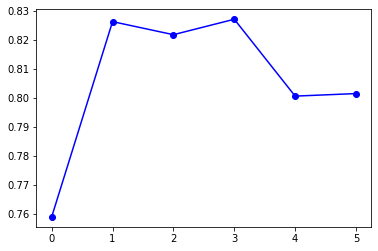

In [81]:
plt.plot(np.arange(len(AUC)), AUC, linestyle='-', marker='o', color='b')

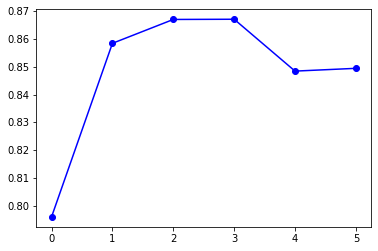

In [82]:
plt.plot(np.arange(len(AUC)), AP, linestyle='-', marker='o', color='b')

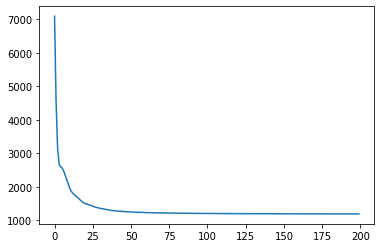

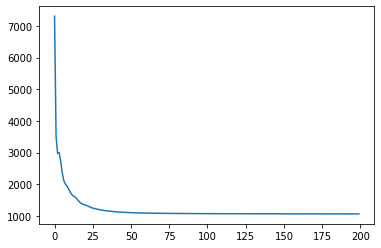

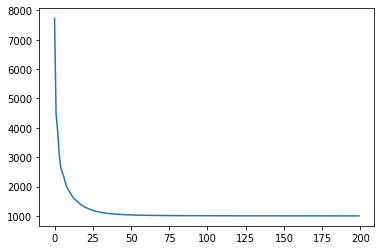

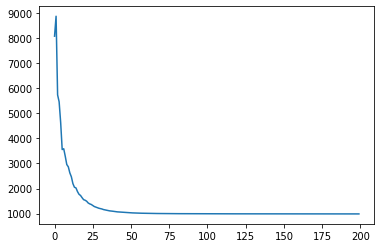

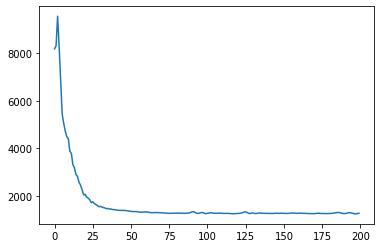

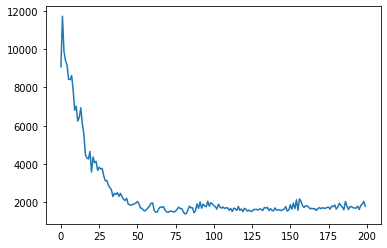

In [83]:
for l in Loss:
    plt.plot(l)
    plt.show()

In [84]:
OLD_AUC=[]
OLD_AP=[]
old_emb=[]
for p in PATCHES:
    prob=l2g.AlignmentProblem(p)
    e=prob.get_aligned_embedding()
    old_emb.append(e)
    auc, ap= full_model_ip.test(torch.tensor(e), test_data.edge_index, neg_edges)
    OLD_AUC.append(auc)
    OLD_AP.append(ap)

Compute relative transformations:   0%|          | 0/168 [00:00<?, ?it/s]

Compute mean embedding:   0%|          | 0/15 [00:00<?, ?it/s]

Compute relative transformations:   0%|          | 0/164 [00:00<?, ?it/s]

Compute mean embedding:   0%|          | 0/15 [00:00<?, ?it/s]

Compute relative transformations:   0%|          | 0/112 [00:00<?, ?it/s]

Compute mean embedding:   0%|          | 0/15 [00:00<?, ?it/s]

Compute relative transformations:   0%|          | 0/44 [00:00<?, ?it/s]

Compute mean embedding:   0%|          | 0/15 [00:00<?, ?it/s]

Compute relative transformations:   0%|          | 0/6 [00:00<?, ?it/s]

Compute mean embedding:   0%|          | 0/15 [00:00<?, ?it/s]

Compute relative transformations: 0it [00:00, ?it/s]

Compute mean embedding:   0%|          | 0/15 [00:00<?, ?it/s]

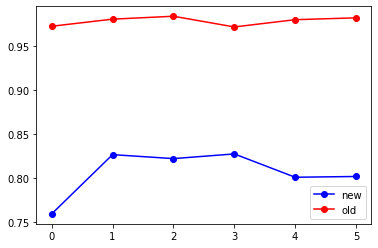

In [85]:
plt.plot(np.arange(len(AUC)), AUC, linestyle='-', marker='o', color='b', label='new')
plt.plot(np.arange(len(AUC)), OLD_AUC, linestyle='-', marker='o', color='r', label='old')
plt.legend()
plt.show()

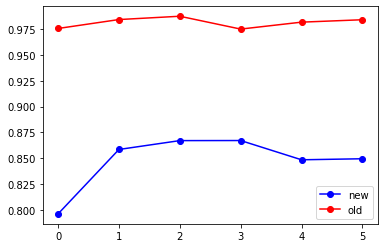

In [86]:
plt.plot(np.arange(len(AUC)), AP, linestyle='-', marker='o', color='b', label='new')
plt.plot(np.arange(len(AUC)), OLD_AP, linestyle='-', marker='o', color='r', label='old')
plt.legend()
plt.show()

In [87]:
from scipy.spatial import procrustes
ERR=[]
for i in range(len(dimensions)):
    _, _, error = procrustes(new_emb[i], old_emb[i])
    ERR.append(error)

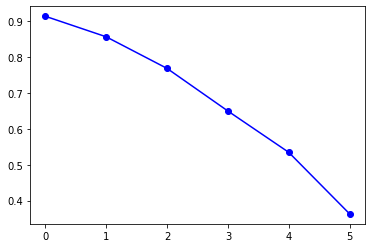

In [89]:
plt.plot(np.arange(len(AUC)), ERR, linestyle='-', marker='o', color='b')